# Data Load

**Dataset Used:**
- Project Gutenberg eBook of [Sense and Sensibility by Jane Austen](https://www.gutenberg.org/ebooks/161)
- Genre: Love

Model: TinyLlama

Total Layers: 23

Layers Analyzed: Layer 0 (First), Layer 15 (2/3rd), Layer 22 (Last)

Each results in a 2 048-dim vector, producing two matrices of shape (2 000 × 2 048).


# Outline

**Clustering Analysis**
- cosine similarity grouping
- DBSCAN
- K-means
- HDBSCAN


In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
import re
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt_tab')

# load raw text
with open('/content/drive/MyDrive/Colab Notebooks/sense_and_sensibility.txt', 'r', encoding='utf-8') as f:
    raw_text = f.read()

# remove start & end blocks
def strip_gutenberg_boilerplate(text: str) -> str:
    start = r'\*\*\* START OF (?:THE|THIS) PROJECT GUTENBERG EBOOK .*? \*\*\*'
    end   = r'\*\*\* END OF (?:THE|THIS) PROJECT GUTENBERG EBOOK .*? \*\*\*'
    text  = re.split(start, text, 1, flags=re.I | re.S)[-1]
    text  = re.split(end,   text, 1, flags=re.I | re.S)[0]
    return text

# remove contents, chapter heads, illustration notes
def extra_cleanup(text: str) -> str:
    text = re.sub(r'\[Illustration.*?\n', ' ', text, flags=re.I)
    text = re.sub(r'Contents.+?CHAPTER\s+I\.', ' ', text,
                  flags=re.I | re.S)

    text = re.sub(r'CHAPTER\s+[IVXLCDM]+\s*\.', ' ', text,
                  flags=re.I)

    # normalise whitespace and remove stray markup chars
    text = re.sub(r'[_*"#]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [3]:
clean_text  = strip_gutenberg_boilerplate(raw_text)
clean_text  = extra_cleanup(clean_text)
sentences_cleaned   = sent_tokenize(clean_text)

print(f"cleaned text: {len(sentences_cleaned):,} sentences")

cleaned text: 3,922 sentences


In [4]:
# get the middle 3000 sentences
total = len(sentences_cleaned)
middle_start = max((total // 2) - 1500, 0)
middle_end = min((total // 2) + 1500, total)

sentences = sentences_cleaned[middle_start:middle_end]

print(f"extracted {len(sentences)} middle sentences (from {middle_start} to {middle_end})")

print(sentences)

extracted 3000 middle sentences (from 461 to 3461)
['“Willoughby!” cried Sir John; “what, is he in the country?', 'That is good news however; I will ride over tomorrow, and ask him to dinner on Thursday.” “You know him then,” said Mrs. Dashwood.', '“Know him!', 'to be sure I do.', 'Why, he is down here every year.” “And what sort of a young man is he?” “As good a kind of fellow as ever lived, I assure you.', 'A very decent shot, and there is not a bolder rider in England.” “And is that all you can say for him?” cried Marianne, indignantly.', '“But what are his manners on more intimate acquaintance?', 'What his pursuits, his talents, and genius?” Sir John was rather puzzled.', '“Upon my soul,” said he, “I do not know much about him as to all that.', 'But he is a pleasant, good humoured fellow, and has got the nicest little black bitch of a pointer I ever saw.', 'Was she out with him today?” But Marianne could no more satisfy him as to the colour of Mr. Willoughby’s pointer, than he coul

# Embedding model – TinyLlama
- tokenize each sentence, run the model, and return all hidden-state tensors.
- Extract last token vector from layer 15, 22

In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords

In [7]:
print("Loading LLaMA model...")
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"  # A smaller LLaMA-like model that's easy to run
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)

Loading LLaMA model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

Using device: cuda


In [9]:
# tokenize text, run it through the model
def get_llama_token_embeddings(text, model, tokenizer, device):
    inputs = tokenizer(text, return_tensors="pt", max_length=256, truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    all_hidden_states = outputs.hidden_states
    last_hidden_state = all_hidden_states[-1]
    return tokens, all_hidden_states, last_hidden_state

In [10]:
# extract the last token vector from a specific layer.
def get_last_token_vector(all_hidden_states, layer_idx):
    layer_output = all_hidden_states[layer_idx]
    last_token_vec = layer_output[:, -1, :].squeeze(0)
    return last_token_vec

In [12]:
_, hidden_states, _ = get_llama_token_embeddings(sentences[0], model, tokenizer, device)
n_all = len(hidden_states)
print(f"Total hidden_states = {n_all}")

# 15th and last
selected_layers = [15, n_all-1]
print(f"Selected layers: {selected_layers}")

selected_layer_embeddings = {layer_idx: [] for layer_idx in selected_layers}

# extract last token embeddings for selected layers for each sentence
for text in tqdm(sentences):
    tokens, all_hidden_states, _ = get_llama_token_embeddings(text, model, tokenizer, device)
    for layer_idx in selected_layers:
        vec = get_last_token_vector(all_hidden_states, layer_idx)
        selected_layer_embeddings[layer_idx].append(vec)

for layer_idx in selected_layers:
    gpu_tensors = selected_layer_embeddings[layer_idx]
    selected_layer_embeddings[layer_idx] = np.array([tensor.cpu().numpy() if torch.is_tensor(tensor) else tensor for tensor in gpu_tensors])
    hidden_dim = selected_layer_embeddings[layer_idx].shape[1]
    print(f"Layer {layer_idx}: {selected_layer_embeddings[layer_idx].shape} (num_sentences: {selected_layer_embeddings[layer_idx].shape[0]}, hidden_dim: {hidden_dim})")
print(f"Selected layers processed: {len(selected_layers)}")

Total hidden_states = 23
Selected layers: [15, 22]


100%|██████████| 3000/3000 [01:23<00:00, 35.82it/s]


Layer 15: (3000, 2048) (num_sentences: 3000, hidden_dim: 2048)
Layer 22: (3000, 2048) (num_sentences: 3000, hidden_dim: 2048)
Selected layers processed: 2


# Norm + Cosine Similarity

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import numpy as np

# cosine similarity for each selected layer
sim_matrix_layers = []
avg_similarity_layers = []


#Compute cosine similarity for each layer's sentence embeddings
for layer_idx in selected_layers:
    embeddings = selected_layer_embeddings[layer_idx]

    sim_matrix = cosine_similarity(embeddings)
    sim_matrix_layers.append(sim_matrix)

    # calculate average similarity
    triu_indices = np.triu_indices_from(sim_matrix, k=1)
    avg_similarity = sim_matrix[triu_indices].mean()
    avg_similarity_layers.append(avg_similarity)

    print(f"\nLayer {layer_idx}:")
    print(f"  Similarity Matrix Shape: {sim_matrix.shape}")
    print(f"  Average Pairwise Cosine Similarity = {avg_similarity:.3f}")



Layer 15:
  Similarity Matrix Shape: (3000, 3000)
  Average Pairwise Cosine Similarity = 0.537

Layer 22:
  Similarity Matrix Shape: (3000, 3000)
  Average Pairwise Cosine Similarity = 0.771


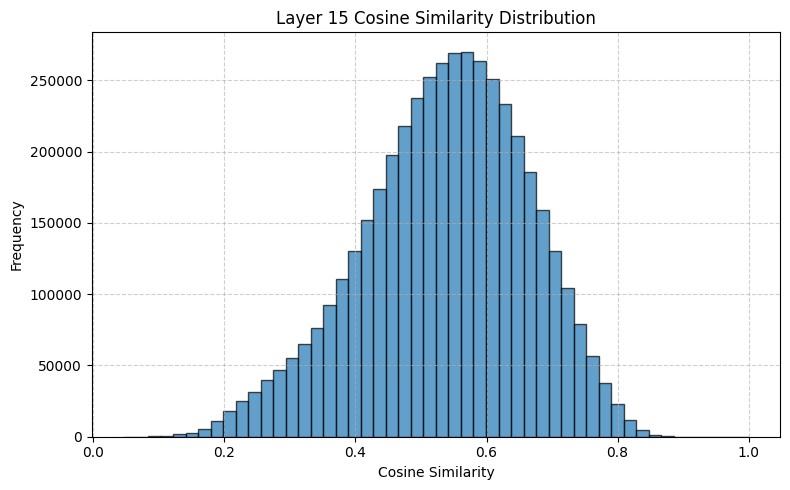


Layer 15 Cosine Similarity Statistics:
Mean: 0.5366
Median: 0.5450
Standard Deviation: 0.1263
Min: 0.0457
Max: 1.0000


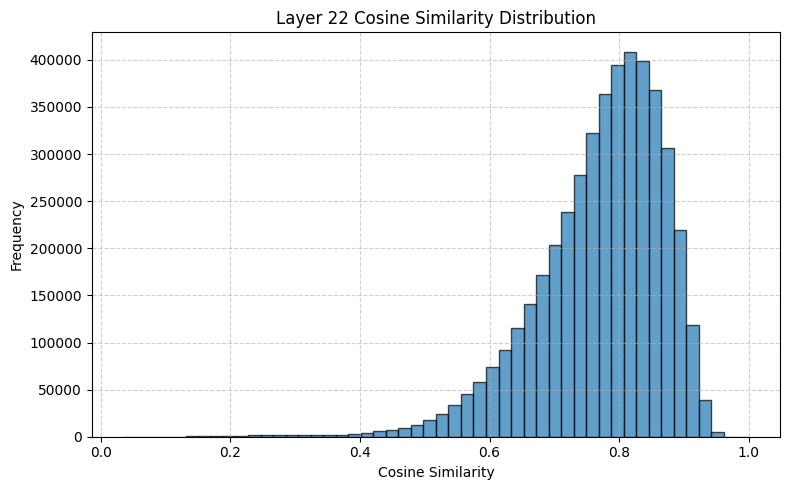


Layer 22 Cosine Similarity Statistics:
Mean: 0.7711
Median: 0.7881
Standard Deviation: 0.0980
Min: 0.0347
Max: 1.0000


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# plot frequency distributions for each layer's normalized similarity matrix

for i, layer_idx in enumerate(selected_layers):
    sim_matrix = sim_matrix_layers[i]

    triu_indices = np.triu_indices_from(sim_matrix, k=1)
    sim_values = sim_matrix[triu_indices]

    plt.figure(figsize=(8, 5))
    plt.hist(sim_values, bins=50, edgecolor='black', alpha=0.7)
    plt.title(f"Layer {layer_idx} Cosine Similarity Distribution")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

    print(f"\nLayer {layer_idx} Cosine Similarity Statistics:")
    print(f"Mean: {np.mean(sim_values):.4f}")
    print(f"Median: {np.median(sim_values):.4f}")
    print(f"Standard Deviation: {np.std(sim_values):.4f}")
    print(f"Min: {np.min(sim_values):.4f}")
    print(f"Max: {np.max(sim_values):.4f}")

# DBSCAN

In [15]:
pip install kneed

In [16]:
from sklearn.cluster import DBSCAN

def clustering_grouping(embedding, thres):
  eps = 1 - thres
  clustering = DBSCAN(eps=eps, min_samples=2, metric="cosine").fit(embedding)
  labels = clustering.labels_

  groups = {}
  for idx, label in enumerate(labels):
    if label not in groups:
      groups[label] = []
    groups[label].append(idx)
  return list(groups.values())

### DBSCAN Analysis: Slope, R-squared values for different eps values

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import os

def linear_regression(counts):
    valid_counts = counts[counts > 0]
    if len(valid_counts) <= 1:
        return None, None, 0, 0, 0, 1, None
    x = np.log10(np.arange(1, len(valid_counts)+1))
    y = np.log10(valid_counts)
    slope, intercept, r_val, p_val, std_err = linregress(x, y)
    y_pred = slope * x + intercept
    return x, y, slope, intercept, r_val, p_val, y_pred

In [18]:
# count sentences in each cluster and sort
def count_sentences_per_cluster_dbscan(clusters):
    counts = [len(cluster) for cluster in clusters]
    return np.array(sorted(counts, reverse=True))

In [19]:
dbscan_similarity_thresholds = np.linspace(0.85, 0.99, num=15)

dbscan_threshold_analysis_results = []

# Analyze each threshold for both layers
for current_similarity_threshold in dbscan_similarity_thresholds:
    # Layer 15 analysis
    layer_15_clusters_at_current_threshold = clustering_grouping(
        selected_layer_embeddings[selected_layers[0]],
        current_similarity_threshold
    )
    layer_15_cluster_sizes_at_current_threshold = count_sentences_per_cluster_dbscan(
        layer_15_clusters_at_current_threshold
    )

    # Get the top 5 cluster sizes for layer 15 (or fewer if there are less than 5 clusters)
    layer_15_top_cluster_sizes = layer_15_cluster_sizes_at_current_threshold[:min(5, len(layer_15_cluster_sizes_at_current_threshold))]
    layer_15_top_cluster_sizes_formatted = ', '.join(map(str, layer_15_top_cluster_sizes))

    # Calculate power law regression metrics for layer 15
    _, _, layer_15_power_law_slope, _, layer_15_r_squared, _, _ = linear_regression(
        layer_15_cluster_sizes_at_current_threshold
    )

    # Layer 22 analysis
    layer_22_clusters_at_current_threshold = clustering_grouping(
        selected_layer_embeddings[selected_layers[1]],
        current_similarity_threshold
    )
    layer_22_cluster_sizes_at_current_threshold = count_sentences_per_cluster_dbscan(
        layer_22_clusters_at_current_threshold
    )

    # Get the top 5 cluster sizes for layer 22 (or fewer if there are less than 5 clusters)
    layer_22_top_cluster_sizes = layer_22_cluster_sizes_at_current_threshold[:min(5, len(layer_22_cluster_sizes_at_current_threshold))]
    layer_22_top_cluster_sizes_formatted = ', '.join(map(str, layer_22_top_cluster_sizes))

    # Calculate power law regression metrics for layer 22
    _, _, layer_22_power_law_slope, _, layer_22_r_squared, _, _ = linear_regression(
        layer_22_cluster_sizes_at_current_threshold
    )

    # Store the analysis results for this threshold
    dbscan_threshold_analysis_results.append({
        'Similarity_Threshold': current_similarity_threshold,
        'Layer_15_Cluster_Count': len(layer_15_clusters_at_current_threshold),
        'Layer_15_Top_Cluster_Sizes': layer_15_top_cluster_sizes_formatted,
        'Layer_15_R_Squared': layer_15_r_squared**2,
        'Layer_15_Power_Law_Slope': layer_15_power_law_slope,
        'Layer_22_Cluster_Count': len(layer_22_clusters_at_current_threshold),
        'Layer_22_Top_Cluster_Sizes': layer_22_top_cluster_sizes_formatted,
        'Layer_22_R_Squared': layer_22_r_squared**2,
        'Layer_22_Power_Law_Slope': layer_22_power_law_slope
    })

# Convert results to DataFrame for easier manipulation and display
dbscan_analysis_results_df = pd.DataFrame(dbscan_threshold_analysis_results)


In [20]:
print(dbscan_analysis_results_df)

    Similarity_Threshold  Layer_15_Cluster_Count Layer_15_Top_Cluster_Sizes  \
0                   0.85                      94       2347, 386, 18, 15, 8   
1                   0.86                      73       2560, 195, 47, 16, 8   
2                   0.87                      60      2693, 109, 16, 16, 14   
3                   0.88                      50       2809, 16, 14, 14, 10   
4                   0.89                      32           2883, 8, 8, 8, 8   
5                   0.90                      28           2903, 8, 8, 8, 7   
6                   0.91                      27           2914, 8, 8, 7, 7   
7                   0.92                      23           2925, 8, 7, 7, 7   
8                   0.93                      20           2935, 8, 7, 6, 6   
9                   0.94                      19           2940, 8, 6, 6, 5   
10                  0.95                      15           2948, 8, 6, 6, 5   
11                  0.96                      16    

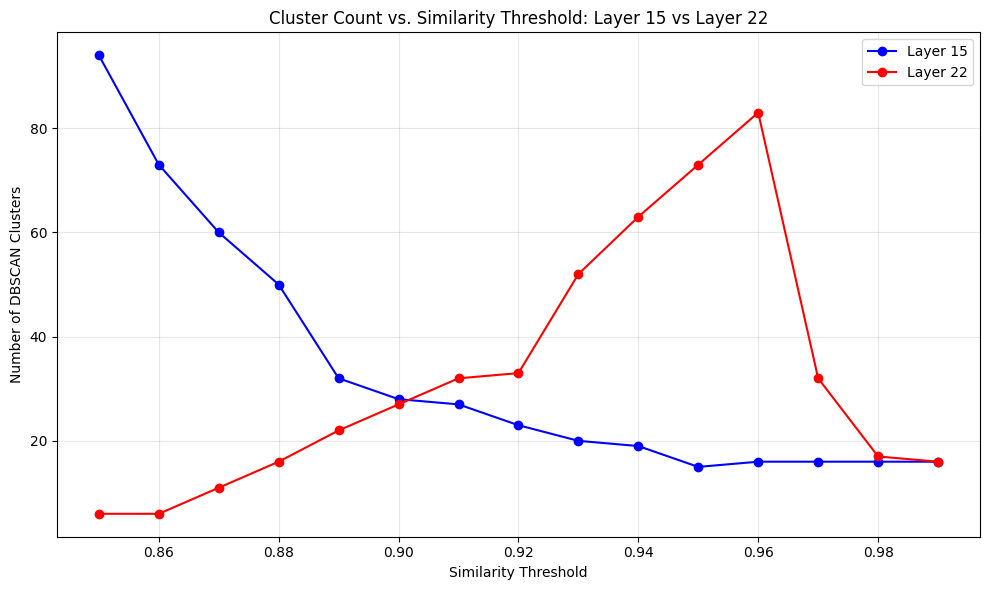

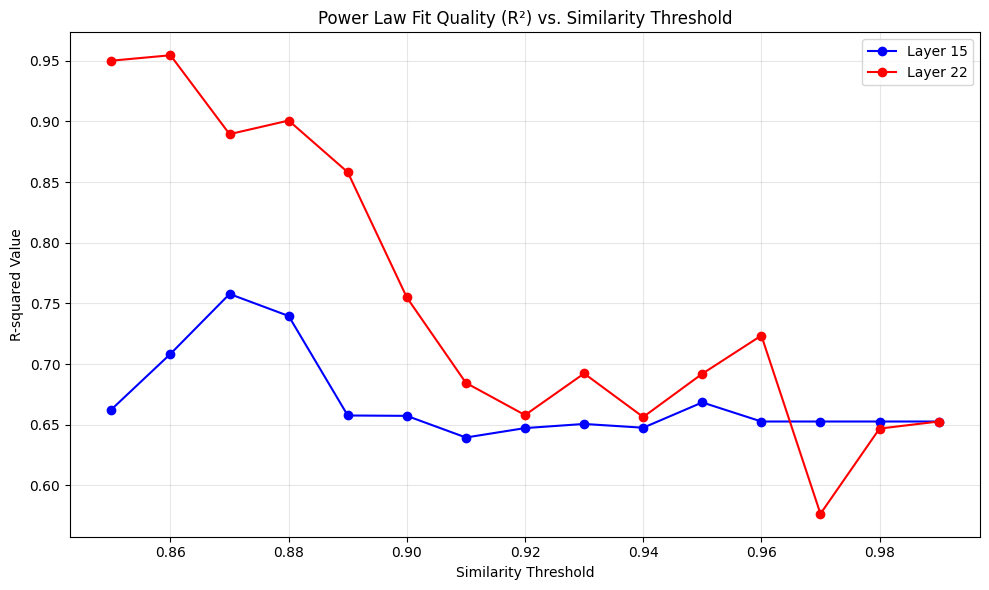

In [21]:
# Create visualization of the crossing pattern between layers
import matplotlib.pyplot as plt

# Plot showing how cluster counts change with similarity threshold
layer_comparison_cluster_count_fig = plt.figure(figsize=(10, 6))
plt.plot(
    dbscan_analysis_results_df['Similarity_Threshold'],
    dbscan_analysis_results_df['Layer_15_Cluster_Count'],
    'b-o',
    label='Layer 15'
)
plt.plot(
    dbscan_analysis_results_df['Similarity_Threshold'],
    dbscan_analysis_results_df['Layer_22_Cluster_Count'],
    'r-o',
    label='Layer 22'
)
plt.xlabel('Similarity Threshold')
plt.ylabel('Number of DBSCAN Clusters')
plt.title('Cluster Count vs. Similarity Threshold: Layer 15 vs Layer 22')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('dbscan_cluster_threshold_comparison.png')
plt.show()

# Plot showing how R² values change with similarity threshold
r_squared_comparison_fig = plt.figure(figsize=(10, 6))
plt.plot(
    dbscan_analysis_results_df['Similarity_Threshold'],
    dbscan_analysis_results_df['Layer_15_R_Squared'],
    'b-o',
    label='Layer 15'
)
plt.plot(
    dbscan_analysis_results_df['Similarity_Threshold'],
    dbscan_analysis_results_df['Layer_22_R_Squared'],
    'r-o',
    label='Layer 22'
)
plt.xlabel('Similarity Threshold')
plt.ylabel('R-squared Value')
plt.title('Power Law Fit Quality (R²) vs. Similarity Threshold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('dbscan_rsquared_threshold_comparison.png')
plt.show()

#### Best threshold

In [22]:
# Find the similarity threshold that produces the highest R² value for each layer
layer_15_best_rsquared_index = dbscan_analysis_results_df['Layer_15_R_Squared'].idxmax()
layer_15_best_rsquared_row = dbscan_analysis_results_df.iloc[layer_15_best_rsquared_index]

layer_22_best_rsquared_index = dbscan_analysis_results_df['Layer_22_R_Squared'].idxmax()
layer_22_best_rsquared_row = dbscan_analysis_results_df.iloc[layer_22_best_rsquared_index]


print("\layer 15 (upper middle layer) OPTIMAL THRESHOLD:")
print(f"Similarity Threshold: {layer_15_best_rsquared_row['Similarity_Threshold']:.2f}")
print(f"R² Value: {layer_15_best_rsquared_row['Layer_15_R_Squared']:.4f}")
print(f"Power Law Slope: {layer_15_best_rsquared_row['Layer_15_Power_Law_Slope']:.4f}")
print(f"Number of Clusters: {layer_15_best_rsquared_row['Layer_15_Cluster_Count']}")
print(f"Top Cluster Sizes: {layer_15_best_rsquared_row['Layer_15_Top_Cluster_Sizes']}")

print("\layer 22 OPTIMAL THRESHOLD:")
print(f"Similarity Threshold: {layer_22_best_rsquared_row['Similarity_Threshold']:.2f}")
print(f"R² Value: {layer_22_best_rsquared_row['Layer_22_R_Squared']:.4f}")
print(f"Power Law Slope: {layer_22_best_rsquared_row['Layer_22_Power_Law_Slope']:.4f}")
print(f"Number of Clusters: {layer_22_best_rsquared_row['Layer_22_Cluster_Count']}")
print(f"Top Cluster Sizes: {layer_22_best_rsquared_row['Layer_22_Top_Cluster_Sizes']}")


\layer 15 (upper middle layer) OPTIMAL THRESHOLD:
Similarity Threshold: 0.87
R² Value: 0.7577
Power Law Slope: -1.1054
Number of Clusters: 60
Top Cluster Sizes: 2693, 109, 16, 16, 14
\layer 22 OPTIMAL THRESHOLD:
Similarity Threshold: 0.86
R² Value: 0.9545
Power Law Slope: -4.3036
Number of Clusters: 6
Top Cluster Sizes: 2907, 76, 11, 2, 2


### Run DBSCAN Final Chosen eps

In [25]:
# middle layer (layer 15)
dbscan_middle_layer = clustering_grouping(selected_layer_embeddings[selected_layers[0]], 0.88)

# last layer (layer 22)
dbscan_last_layer = clustering_grouping(selected_layer_embeddings[selected_layers[1]], 0.88)


print(f"\nMiddle layer (Layer {selected_layers[0]}):")
print(f"Number of clusters: {len(dbscan_middle_layer)}")

print(f"\nLast layer (Layer {selected_layers[1]}):")
print(f"Number of clusters: {len(dbscan_last_layer)}")


Middle layer (Layer 15):
Number of clusters: 50

Last layer (Layer 22):
Number of clusters: 16


In [26]:
import numpy as np


# count sentences per cluster for each layer
vector_sent_dbscan_middle = count_sentences_per_cluster_dbscan(dbscan_middle_layer)
vector_sent_dbscan_last = count_sentences_per_cluster_dbscan(dbscan_last_layer)

print("\nUpper Middle layer sentence counts (sorted):")
print(vector_sent_dbscan_middle)

print("\nLast layer sentence counts (sorted):")
print(vector_sent_dbscan_last)



Upper Middle layer sentence counts (sorted):
[2809   16   14   14   10    8    8    7    5    5    5    5    5    5
    4    4    3    3    3    3    3    3    3    3    2    2    2    2
    2    2    2    2    2    2    2    2    2    2    2    2    2    2
    2    2    2    2    2    2    2    2]

Last layer sentence counts (sorted):
[2736  156   64   11    6    4    4    3    2    2    2    2    2    2
    2    2]


### **KMEANS**

In [27]:
pip install kneed

In [28]:
# Normalize embeddings
norm_layer_15 = normalize(selected_layer_embeddings[selected_layers[0]], norm='l2')
norm_layer_22 = normalize(selected_layer_embeddings[selected_layers[1]], norm='l2')

In [29]:
from kneed import KneeLocator

def find_optimal_k(embeddings, k_samples=None, k_min=5, k_max=50, k_step=None, random_sampling=False, plot=True):
    # random sampling or sequential?
    if random_sampling:
        random.seed(42)
        K = sorted(random.sample(range(k_min, k_max + 1), k_samples))
    else:
        K = list(range(k_min, k_max + 1, k_step if k_step else 1))

    # calculate WCSS for each k value
    wcss = []
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(embeddings)
        wcss.append(kmeans.inertia_)

    # find the knee point using KneeLocator
    knee = KneeLocator(K, wcss, curve='convex', direction='decreasing')
    optimal_k = knee.knee

    # plot the results if plot=True
    if plot and optimal_k:
        plt.figure(figsize=(8, 5))
        plt.plot(K, wcss, 'bo-', label='WCSS')
        plt.axvline(optimal_k, color='red', linestyle='--', label=f'Knee at k={optimal_k}')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('WCSS (Inertia)')
        plt.title('Elbow Method for Optimal k')
        plt.legend()
        plt.grid(True)
        plt.show()

    return optimal_k


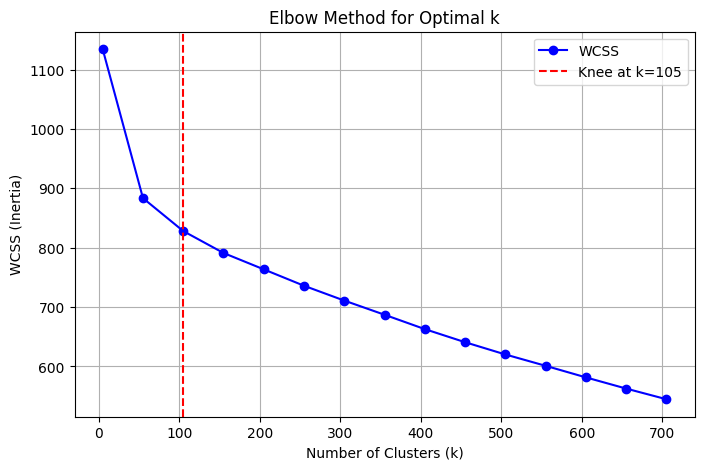

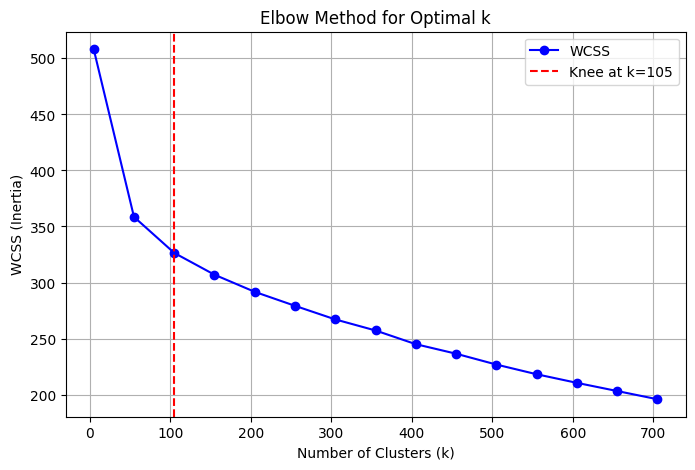

In [30]:
optimal_k_15 = find_optimal_k(norm_layer_15, k_min=5, k_max=705, k_step=50)
optimal_k_22 = find_optimal_k(norm_layer_22, k_min=5, k_max=705, k_step=50)

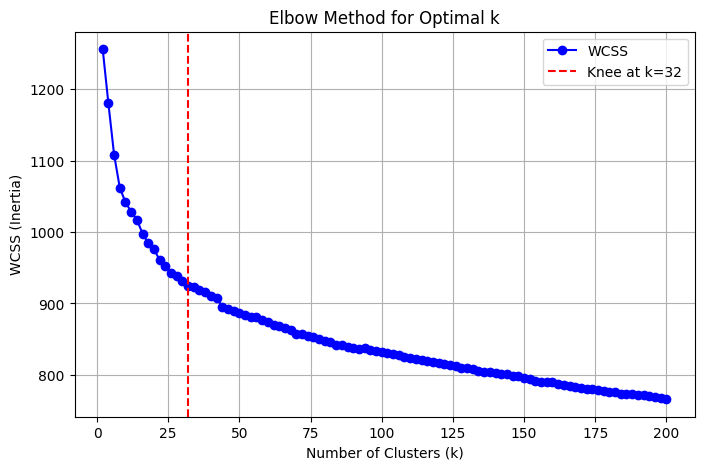

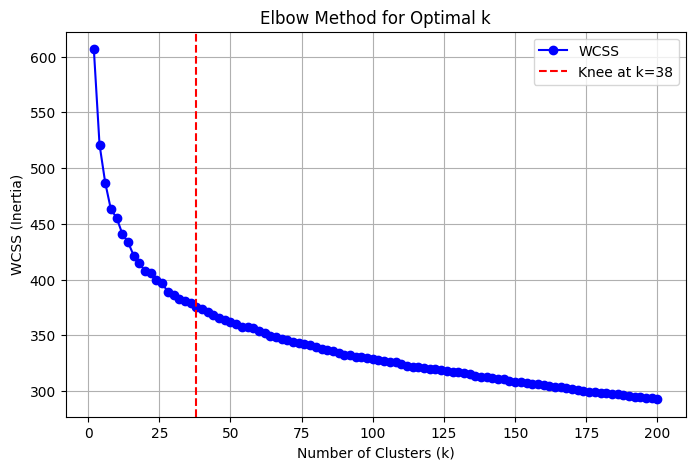

In [31]:
optimal_k_15 = find_optimal_k(norm_layer_15, k_min=2, k_max=200, k_step=2)
optimal_k_22 = find_optimal_k(norm_layer_22, k_min=2, k_max=200, k_step=2)

In [32]:
kmeans_middle_layer = KMeans(n_clusters=32, random_state=42)
kmeans_last_layer = KMeans(n_clusters=38, random_state=42)

# Fit K-means to the raw embeddings
middle_layer_labels = kmeans_middle_layer.fit_predict(norm_layer_15)
last_layer_labels = kmeans_last_layer.fit_predict(norm_layer_22)


In [33]:
def count_sentences_per_cluster(cluster_labels):
    unique, counts = np.unique(cluster_labels, return_counts=True)
    return counts

sentences_per_cluster_middle = count_sentences_per_cluster(middle_layer_labels)
sentences_per_cluster_last = count_sentences_per_cluster(last_layer_labels)

# sentence count stored in vector
import numpy as np

vector_sent_kmeans_mid = np.array(sorted(sentences_per_cluster_middle, reverse=True))
vector_sent_kmeans_last = np.array(sorted(sentences_per_cluster_last, reverse=True))


print("\nmiddle layer sentence counts (sorted):")
print(vector_sent_kmeans_mid)

print("\nlast layer sentence counts (sorted):")
print(vector_sent_kmeans_last)


middle layer sentence counts (sorted):
[181 149 144 130 128 128 128 127 119 116 106 103 101  99  95  90  86  84
  83  83  81  79  77  75  72  65  57  54  53  52  37  18]

last layer sentence counts (sorted):
[161 155 141 131 126 122 111 111 109 109 108 108  99  94  92  84  78  77
  76  75  70  63  61  59  58  58  58  57  50  49  48  45  38  37  31  29
  15   7]


# **Cosine Similarity Grouping**

In [34]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def grouping(cos_similar, n, thres):
  groups = []
  visited = set()

  for i in range(n):
    if i in visited:
      continue

    group = [i]
    visited.add(i)

    for j in range(i+1, n):
      if cos_similar[i][j] >= thres:
        group.append(j)
        visited.add(j)

    groups.append(group)

  return groups

### Examine Cosine similarity thresholds vs. R-squared and slope

In [35]:
# function to extract sorted counts of sentences per cluster
def count_sentences_per_cluster_grouping(groups):
    counts = [len(group) for group in groups]
    return np.array(sorted(counts, reverse=True))

In [36]:
cosine_similarity_thresholds = np.linspace(0.6, 0.99, num=40)

# create a results table for tracking metrics across thresholds
cosine_grouping_threshold_analysis_results = []

layer_15_embeddings = selected_layer_embeddings[selected_layers[0]]
layer_22_embeddings = selected_layer_embeddings[selected_layers[1]]

layer_15_cosine_similarity_matrix = cosine_similarity(layer_15_embeddings)
layer_22_cosine_similarity_matrix = cosine_similarity(layer_22_embeddings)

n_samples_layer_15 = layer_15_embeddings.shape[0]
n_samples_layer_22 = layer_22_embeddings.shape[0]

# analyze each threshold for both layers
for current_similarity_threshold in cosine_similarity_thresholds:
    # layer 15 analysis
    layer_15_groups_at_current_threshold = grouping(
        layer_15_cosine_similarity_matrix,
        n_samples_layer_15,
        current_similarity_threshold
    )
    layer_15_group_sizes_at_current_threshold = count_sentences_per_cluster_grouping(
        layer_15_groups_at_current_threshold
    )

    # top 5 group sizes
    layer_15_top_group_sizes = layer_15_group_sizes_at_current_threshold[:min(5, len(layer_15_group_sizes_at_current_threshold))]
    layer_15_top_group_sizes_formatted = ', '.join(map(str, layer_15_top_group_sizes))

    # power law regression metrics
    _, _, layer_15_power_law_slope, _, layer_15_r_squared, _, _ = linear_regression(
        layer_15_group_sizes_at_current_threshold
    )

    # layer 22 analysis
    layer_22_groups_at_current_threshold = grouping(
        layer_22_cosine_similarity_matrix,
        n_samples_layer_22,
        current_similarity_threshold
    )
    layer_22_group_sizes_at_current_threshold = count_sentences_per_cluster_grouping(
        layer_22_groups_at_current_threshold
    )

    # top 5 group sizes
    layer_22_top_group_sizes = layer_22_group_sizes_at_current_threshold[:min(5, len(layer_22_group_sizes_at_current_threshold))]
    layer_22_top_group_sizes_formatted = ', '.join(map(str, layer_22_top_group_sizes))

    # power law regression metrics
    _, _, layer_22_power_law_slope, _, layer_22_r_squared, _, _ = linear_regression(
        layer_22_group_sizes_at_current_threshold
    )

    # store analysis results
    cosine_grouping_threshold_analysis_results.append({
        'Similarity_Threshold': current_similarity_threshold,
        'Layer_15_Group_Count': len(layer_15_groups_at_current_threshold),
        'Layer_15_Top_Group_Sizes': layer_15_top_group_sizes_formatted,
        'Layer_15_R_Squared': layer_15_r_squared**2,
        'Layer_15_Power_Law_Slope': layer_15_power_law_slope,
        'Layer_22_Group_Count': len(layer_22_groups_at_current_threshold),
        'Layer_22_Top_Group_Sizes': layer_22_top_group_sizes_formatted,
        'Layer_22_R_Squared': layer_22_r_squared**2,
        'Layer_22_Power_Law_Slope': layer_22_power_law_slope
    })

# results to dataframe
cosine_grouping_results_df = pd.DataFrame(cosine_grouping_threshold_analysis_results)

In [37]:
print(cosine_grouping_results_df)

    Similarity_Threshold  Layer_15_Group_Count  Layer_15_Top_Group_Sizes  \
0                   0.60                    90  1621, 832, 822, 773, 642   
1                   0.61                   117  1526, 780, 777, 699, 692   
2                   0.62                   141  1444, 944, 664, 613, 582   
3                   0.63                   153  1338, 967, 887, 592, 533   
4                   0.64                   179  1252, 835, 793, 682, 512   
5                   0.65                   212  1155, 856, 748, 711, 647   
6                   0.66                   260  1070, 701, 654, 599, 589   
7                   0.67                   313   996, 558, 521, 495, 478   
8                   0.68                   366   899, 659, 487, 409, 395   
9                   0.69                   418   795, 572, 413, 409, 309   
10                  0.70                   487   710, 491, 345, 297, 284   
11                  0.71                   575   636, 403, 318, 292, 282   
12          

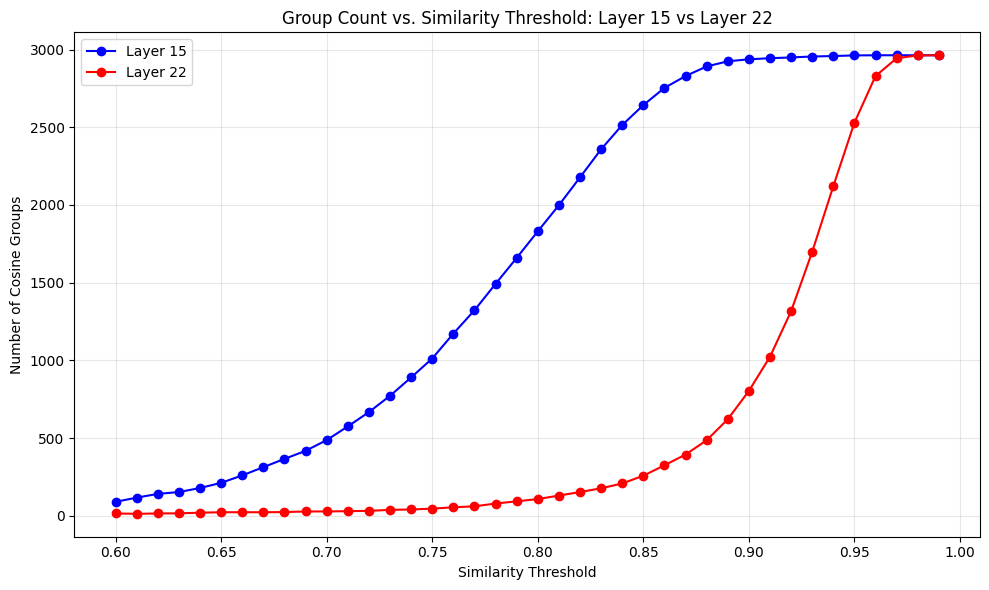

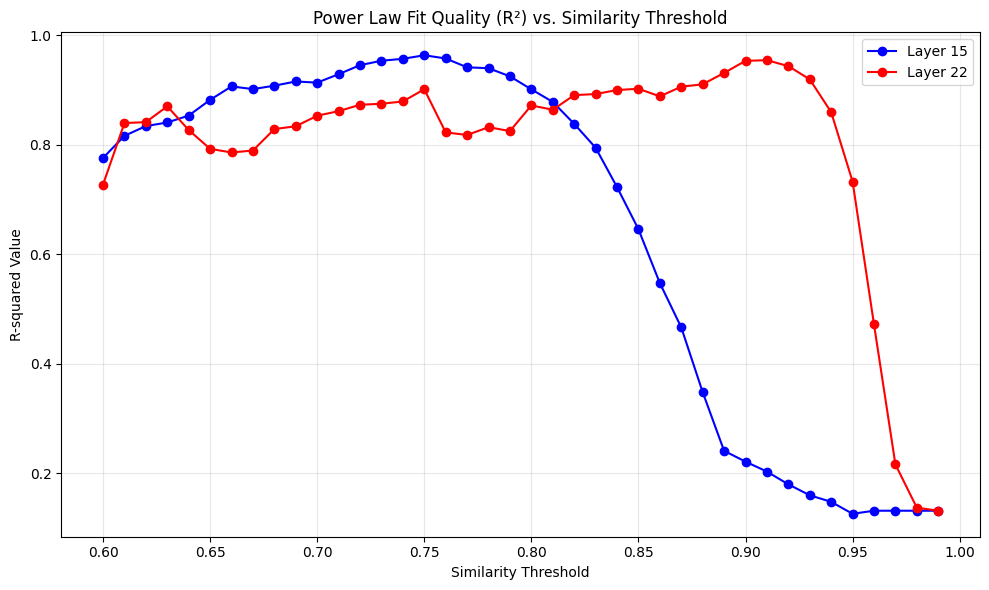

In [38]:
# Plot showing how group counts change with similarity threshold
layer_comparison_group_count_fig = plt.figure(figsize=(10, 6))
plt.plot(
    cosine_grouping_results_df['Similarity_Threshold'],
    cosine_grouping_results_df['Layer_15_Group_Count'],
    'b-o',
    label='Layer 15'
)
plt.plot(
    cosine_grouping_results_df['Similarity_Threshold'],
    cosine_grouping_results_df['Layer_22_Group_Count'],
    'r-o',
    label='Layer 22'
)
plt.xlabel('Similarity Threshold')
plt.ylabel('Number of Cosine Groups')
plt.title('Group Count vs. Similarity Threshold: Layer 15 vs Layer 22')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('cosine_group_threshold_comparison.png')
plt.show()


# Plot showing how R² values change with similarity threshold
r_squared_comparison_fig = plt.figure(figsize=(10, 6))
plt.plot(
    cosine_grouping_results_df['Similarity_Threshold'],
    cosine_grouping_results_df['Layer_15_R_Squared'],
    'b-o',
    label='Layer 15'
)
plt.plot(
    cosine_grouping_results_df['Similarity_Threshold'],
    cosine_grouping_results_df['Layer_22_R_Squared'],
    'r-o',
    label='Layer 22'
)
plt.xlabel('Similarity Threshold')
plt.ylabel('R-squared Value')
plt.title('Power Law Fit Quality (R²) vs. Similarity Threshold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('cosine_rsquared_threshold_comparison.png')
plt.show()

In [39]:
# find similarity threshold that produces the highest R² value for each layer
layer_15_best_rsquared_index = cosine_grouping_results_df['Layer_15_R_Squared'].idxmax()
layer_15_best_rsquared_row = cosine_grouping_results_df.iloc[layer_15_best_rsquared_index]

layer_22_best_rsquared_index = cosine_grouping_results_df['Layer_22_R_Squared'].idxmax()
layer_22_best_rsquared_row = cosine_grouping_results_df.iloc[layer_22_best_rsquared_index]

# best thresholds for each layer
cos_group_15_best_thres = layer_15_best_rsquared_row['Similarity_Threshold']
cos_group_22_best_thres = layer_22_best_rsquared_row['Similarity_Threshold']


print("OPTIMAL SIMILARITY THRESHOLDS BASED ON POWER LAW FIT (R²) - COSINE GROUPING")

print("\nLAYER 15 (MIDDLE LAYER) OPTIMAL THRESHOLD:")
print(f"Similarity Threshold: {cos_group_15_best_thres}")
print(f"R² Value: {layer_15_best_rsquared_row['Layer_15_R_Squared']:.4f}")
print(f"Power Law Slope: {layer_15_best_rsquared_row['Layer_15_Power_Law_Slope']:.4f}")
print(f"Number of Groups: {layer_15_best_rsquared_row['Layer_15_Group_Count']}")
print(f"Top Group Sizes: {layer_15_best_rsquared_row['Layer_15_Top_Group_Sizes']}")

print("\nLAYER 22 (FINAL LAYER) OPTIMAL THRESHOLD:")
print(f"Similarity Threshold: {cos_group_22_best_thres}")
print(f"R² Value: {layer_22_best_rsquared_row['Layer_22_R_Squared']:.4f}")
print(f"Power Law Slope: {layer_22_best_rsquared_row['Layer_22_Power_Law_Slope']:.4f}")
print(f"Number of Groups: {layer_22_best_rsquared_row['Layer_22_Group_Count']}")
print(f"Top Group Sizes: {layer_22_best_rsquared_row['Layer_22_Top_Group_Sizes']}")

OPTIMAL SIMILARITY THRESHOLDS BASED ON POWER LAW FIT (R²) - COSINE GROUPING

LAYER 15 (MIDDLE LAYER) OPTIMAL THRESHOLD:
Similarity Threshold: 0.75
R² Value: 0.9634
Power Law Slope: -1.2065
Number of Groups: 1012
Top Group Sizes: 455, 285, 275, 211, 193

LAYER 22 (FINAL LAYER) OPTIMAL THRESHOLD:
Similarity Threshold: 0.9099999999999999
R² Value: 0.9544
Power Law Slope: -1.2014
Number of Groups: 1023
Top Group Sizes: 335, 210, 209, 180, 175


# Cosine Similarity Grouping using Layer 15 Best Threshold

In [40]:
layer_15_cosine_grouping = grouping(
  layer_15_cosine_similarity_matrix,
  n_samples_layer_15,
  cos_group_15_best_thres
)

vector_best_mid_thres_cosine_grouping_middle = count_sentences_per_cluster_grouping(
    layer_15_cosine_grouping)

print(f"\nUpper middle layer (Layer {selected_layers[0]}) using layer 15's best Threshold ({cos_group_15_best_thres:.2f}):")
print(f"Number of groups: {len(layer_15_cosine_grouping)}")
print(f"Vector for group counts(first 10): {vector_best_mid_thres_cosine_grouping_middle[:10]}")

layer_22_cosine_grouping = grouping(
  layer_22_cosine_similarity_matrix,
  n_samples_layer_22,
  cos_group_15_best_thres
)

vector_best_mid_thres_cosine_grouping_final = count_sentences_per_cluster_grouping(
    layer_22_cosine_grouping
)

print(f"\nFinal layer (Layer {selected_layers[1]}) using layer 15's best Threshold ({cos_group_15_best_thres:.2f}):")
print(f"Number of groups: {len(layer_22_cosine_grouping)}")
print(f"Vector for group counts (first 10): {vector_best_mid_thres_cosine_grouping_final[:10]}")



Upper middle layer (Layer 15) using layer 15's best Threshold (0.75):
Number of groups: 1012
Vector for group counts(first 10): [455 285 275 211 193 165 155 135 128 122]

Final layer (Layer 22) using layer 15's best Threshold (0.75):
Number of groups: 46
Vector for group counts (first 10): [2163 2153 1089 1047  820  747  539  483  203  170]


# Cosine Similarity Grouping using Layer 22 Best Threshold

In [41]:
layer_15_cosine_grouping = grouping(
  layer_15_cosine_similarity_matrix,
  n_samples_layer_15,
  cos_group_22_best_thres
)

vector_best_final_thres_cosine_grouping_middle = count_sentences_per_cluster_grouping(
    layer_15_cosine_grouping)

print(f"\nUpper middle layer (Layer {selected_layers[0]}) using layer 22's best Threshold ({cos_group_22_best_thres:.2f}):")
print(f"Number of groups: {len(layer_15_cosine_grouping)}")
print(f"Vector for group counts(first 10): {vector_best_final_thres_cosine_grouping_middle[:10]}")

layer_22_cosine_grouping = grouping(
  layer_22_cosine_similarity_matrix,
  n_samples_layer_22,
  cos_group_22_best_thres
)

vector_best_final_thres_cosine_grouping_final = count_sentences_per_cluster_grouping(
    layer_22_cosine_grouping
)

print(f"\nFinal layer (Layer {selected_layers[1]}) using layer 22's best Threshold ({cos_group_22_best_thres:.2f}):")
print(f"Number of groups: {len(layer_22_cosine_grouping)}")
print(f"Vector for group counts (first 10): {vector_best_final_thres_cosine_grouping_final[:10]}")



Upper middle layer (Layer 15) using layer 22's best Threshold (0.91):
Number of groups: 2944
Vector for group counts(first 10): [8 7 7 6 5 4 4 3 3 3]

Final layer (Layer 22) using layer 22's best Threshold (0.91):
Number of groups: 1023
Vector for group counts (first 10): [335 210 209 180 175 167 163 132 120 117]


# HDBSCAN
- min_cluster_size = 2


In [42]:
import random
from functools import partial
import hdbscan
import umap
import tensorflow as tf
import tensorflow_hub as hub
from sentence_transformers import SentenceTransformer
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from tqdm.notebook import trange
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials

def hdbscan_clusters(message_embeddings,
                      n_neighbors,
                      n_components,
                      min_samples = None,
                      random_state = None):

    umap_embeddings = (umap.UMAP(n_neighbors = n_neighbors,
                                n_components = n_components,
                                metric = 'cosine',
                                random_state=random_state)
                            .fit_transform(message_embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = 2,
                               min_samples = min_samples,
                               metric='euclidean',
                               gen_min_span_tree=True,
                               cluster_selection_method='eom').fit(umap_embeddings)

    return clusters

In [43]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 22.8 MB/s eta 0:00:00


###HDBSCAN UMAP hyperparameter tuning using Optuna

In [44]:
# tune UMAP hyper-parameters using Optuna
# Optuna runs one trial per grid point
import optuna
import umap
from hdbscan import HDBSCAN
from sklearn.metrics import silhouette_score
from functools import partial


MIN_CLUSTER_SIZE = 2
MIN_SAMPLES      = None

def objective(trial, data):
    n_components = trial.suggest_int("n_components", 10, 40, step=5)
    n_neighbors  = trial.suggest_int("n_neighbors",  10, 40, step=5)

    reducer   = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        random_state=42,
        metric="euclidean",
        low_memory=True,
    )
    embedding = reducer.fit_transform(data)

    labels = HDBSCAN(
        min_cluster_size=MIN_CLUSTER_SIZE,

        **({} if MIN_SAMPLES is None else {"min_samples": MIN_SAMPLES})
    ).fit_predict(embedding)

    return silhouette_score(embedding, labels) if len(set(labels)) > 1 else -1

search_space = {
    "n_components": list(range(10, 41, 5)),
    "n_neighbors" : list(range(10, 41, 5)),
}

In [45]:
def tune_umap(data):
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.GridSampler(search_space),
    )
    study.optimize(partial(objective, data=data))
    return study

In [46]:
layer15_study = tune_umap(norm_layer_15)
print("Layer 15 best score :", layer15_study.best_value)
print("Layer 15 best params:", layer15_study.best_params)

[I 2025-05-13 04:59:50,103] A new study created in memory with name: no-name-0ee6e553-0ce4-4153-84fc-588e878ee88d
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-13 05:00:21,898] Trial 0 finished with value: 0.6087416410446167 and parameters: {'n_components': 30, 'n_neighbors': 15}. Be

Layer 15 best score : 0.6285462379455566
Layer 15 best params: {'n_components': 15, 'n_neighbors': 15}


In [47]:
layer22_study = tune_umap(norm_layer_22)
print("Layer 22 best score :", layer22_study.best_value)
print("Layer 22 best params:", layer22_study.best_params)

[I 2025-05-13 05:18:56,914] A new study created in memory with name: no-name-6cb3ec73-15cb-40e5-8b18-a22ef782334c
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-13 05:19:22,504] Trial 0 finished with value: 0.45188963413238525 and parameters: {'n_components': 30, 'n_neighbors': 15}. B

Layer 22 best score : 0.661273181438446
Layer 22 best params: {'n_components': 20, 'n_neighbors': 10}


### Run HDBSCAN

In [48]:
# count sentences per cluster
def count_sentences_per_hdbscan_cluster(cluster_labels):
    num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    counts = np.zeros(num_clusters, dtype=int)

    for label in cluster_labels:
        # skip noise points
        if label != -1:
            counts[label] += 1

    return counts

### HDBSCAN using best params for layer 15

In [49]:
import numpy as np

# Layer 15
clusters15_best15 = hdbscan_clusters(
    norm_layer_15,
    n_neighbors=15,
    n_components=15,
    random_state=42
)
labels_hdbscan15_best15 = clusters15_best15.labels_
num_clusters15_best15 = len(set(labels_hdbscan15_best15)) - (1 if -1 in labels_hdbscan15_best15 else 0)
print(f"Layer 15 (using best params for layer 15): {num_clusters15_best15} clusters")

# Layer 22
clusters22_best15 = hdbscan_clusters(
    norm_layer_22,
    n_neighbors=15,
    n_components=15,
    random_state=42
)
labels_hdbscan22_best15 = clusters22_best15.labels_
num_clusters22_best15 = len(set(labels_hdbscan22_best15)) - (1 if -1 in labels_hdbscan22_best15 else 0)
print(f"Layer 22 (using best params for layer 15): {num_clusters22_best15} clusters")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:

Layer 15 (using best params for layer 15): 37 clusters
Layer 22 (using best params for layer 15): 47 clusters


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [50]:
# count sentences per cluster for each layer
sentence_counts_hdbscan_layer15_best15 = count_sentences_per_hdbscan_cluster(labels_hdbscan15_best15)
sentence_counts_hdbscan_layer22_best15 = count_sentences_per_hdbscan_cluster(labels_hdbscan22_best15)

# vectorize and sort the counts in descending order
vector_sent_hdbscan_layer15_best15 = np.array(sorted(sentence_counts_hdbscan_layer15_best15, reverse=True))
vector_sent_hdbscan_layer22_best15 = np.array(sorted(sentence_counts_hdbscan_layer22_best15, reverse=True))


# Print the distribution of sentences across clusters
print("\nDistribution of sentences across clusters: ")

print(f"\nLayer 15 ({num_clusters15_best15} clusters):")
print(f"Total sentences in clusters: {np.sum(vector_sent_hdbscan_layer15_best15)}")
print(f"Noise points: {np.sum(labels_hdbscan15_best15 == -1)}")
print(f"Top 5 clusters: {vector_sent_hdbscan_layer15_best15[:5]}")
print(f"Sentence distribution: {vector_sent_hdbscan_layer15_best15}")

print(f"\nLayer 22 ({num_clusters22_best15} clusters):")
print(f"Total sentences in clusters: {np.sum(vector_sent_hdbscan_layer22_best15)}")
print(f"Noise points: {np.sum(labels_hdbscan22_best15 == -1)}")
print(f"Top 5 clusters: {vector_sent_hdbscan_layer22_best15[:5]}")
print(f"Sentence distribution: {vector_sent_hdbscan_layer22_best15}")



Distribution of sentences across clusters: 

Layer 15 (37 clusters):
Total sentences in clusters: 2942
Noise points: 58
Top 5 clusters: [2524  167   18   15   13]
Sentence distribution: [2524  167   18   15   13   12   12   11   10   10   10   10    9    9
    8    8    8    8    6    6    6    6    6    6    6    6    4    4
    3    3    3    3    3    3    2    2    2]

Layer 22 (47 clusters):
Total sentences in clusters: 2894
Noise points: 106
Top 5 clusters: [2161  359  103   23   16]
Sentence distribution: [2161  359  103   23   16   14   12   12   10   10   10    9    8    8
    7    7    7    7    6    6    6    6    6    6    5    5    4    4
    4    4    4    4    4    3    3    3    3    3    3    3    3    3
    2    2    2    2    2]


### HDBSCAN using best params for layer 22

In [51]:
# Layer 15
clusters15_best22 = hdbscan_clusters(
    norm_layer_15,
    n_neighbors=10,
    n_components=20,
    random_state=42
)
labels_hdbscan15_best22 = clusters15_best22.labels_
num_clusters15_best22 = len(set(labels_hdbscan15_best22)) - (1 if -1 in labels_hdbscan15_best22 else 0)
print(f"Layer 15 (using best params for layer 22): {num_clusters15_best22} clusters")

# Layer 22
clusters22_best22 = hdbscan_clusters(
    norm_layer_22,
    n_neighbors=10,
    n_components=20,
    random_state=42
)
labels_hdbscan22_best22 = clusters22_best22.labels_
num_clusters22_best22 = len(set(labels_hdbscan22_best22)) - (1 if -1 in labels_hdbscan22_best22 else 0)
print(f"Layer 22 (using best params for layer 22): {num_clusters22_best22} clusters")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:

Layer 15 (using best params for layer 22): 329 clusters
Layer 22 (using best params for layer 22): 301 clusters


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [52]:
# count sentences per cluster for each layer
sentence_counts_hdbscan_layer15_best22 = count_sentences_per_hdbscan_cluster(labels_hdbscan15_best22)
sentence_counts_hdbscan_layer22_best22 = count_sentences_per_hdbscan_cluster(labels_hdbscan22_best22)

# vectorize and sort the counts in descending order
vector_sent_hdbscan_layer15_best22 = np.array(sorted(sentence_counts_hdbscan_layer15_best22, reverse=True))
vector_sent_hdbscan_layer22_best22 = np.array(sorted(sentence_counts_hdbscan_layer22_best22, reverse=True))

# Print the distribution of sentences across clusters
print("\nDistribution of sentences across clusters: ")

print(f"\nLayer 15 ({num_clusters15_best22} clusters):")
print(f"Total sentences in clusters: {np.sum(vector_sent_hdbscan_layer15_best22)}")
print(f"Noise points: {np.sum(labels_hdbscan15_best22 == -1)}")
print(f"Top 5 clusters: {vector_sent_hdbscan_layer15_best22[:5]}")
print(f"Sentence distribution: {vector_sent_hdbscan_layer15_best22}")

print(f"\nLayer 22 ({num_clusters22_best22} clusters):")
print(f"Total sentences in clusters: {np.sum(vector_sent_hdbscan_layer22_best22)}")
print(f"Noise points: {np.sum(labels_hdbscan22_best22 == -1)}")
print(f"Top 5 clusters: {vector_sent_hdbscan_layer22_best22[:5]}")
print(f"Sentence distribution: {vector_sent_hdbscan_layer22_best22}")



Distribution of sentences across clusters: 

Layer 15 (329 clusters):
Total sentences in clusters: 2137
Noise points: 863
Top 5 clusters: [346  29  25  22  19]
Sentence distribution: [346  29  25  22  19  19  19  17  17  16  14  14  14  14  14  14  14  13
  13  13  13  13  12  12  12  12  12  11  11  11  11  11  11  11  11  10
  10  10  10  10  10  10  10  10  10  10   9   9   9   9   9   9   9   9
   9   8   8   8   8   8   8   8   8   8   7   7   7   7   7   7   7   7
   7   7   7   7   7   7   7   7   7   7   7   6   6   6   6   6   6   6
   6   6   6   6   6   6   6   6   6   6   6   6   6   6   6   6   6   6
   6   6   6   6   6   6   6   6   6   6   6   5   5   5   5   5   5   5
   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5
   5   5   5   5   4   4   4   4   4   4   4   4   4   4   4   4   4   4
   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4
   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   3
   3   3   3 

# Plot

Saved plot: new_clustering_wiki_plots/Layer 15 - DBSCAN Clustering_wiki.png


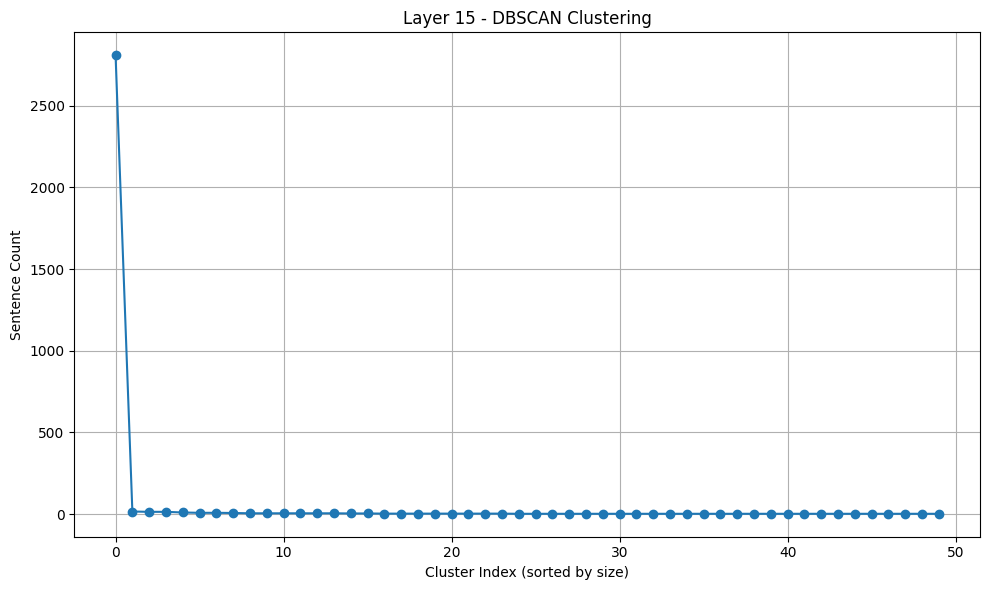

Saved plot: new_clustering_wiki_plots/Last Layer - DBSCAN Clustering_wiki.png


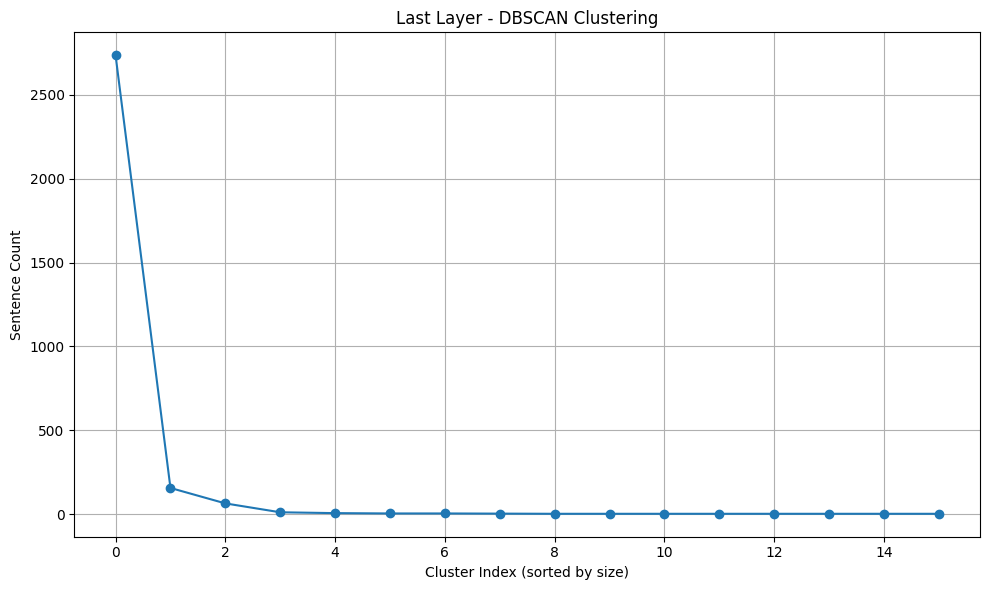

Saved plot: new_clustering_wiki_plots/Layer 15 - K-means Clustering_wiki.png


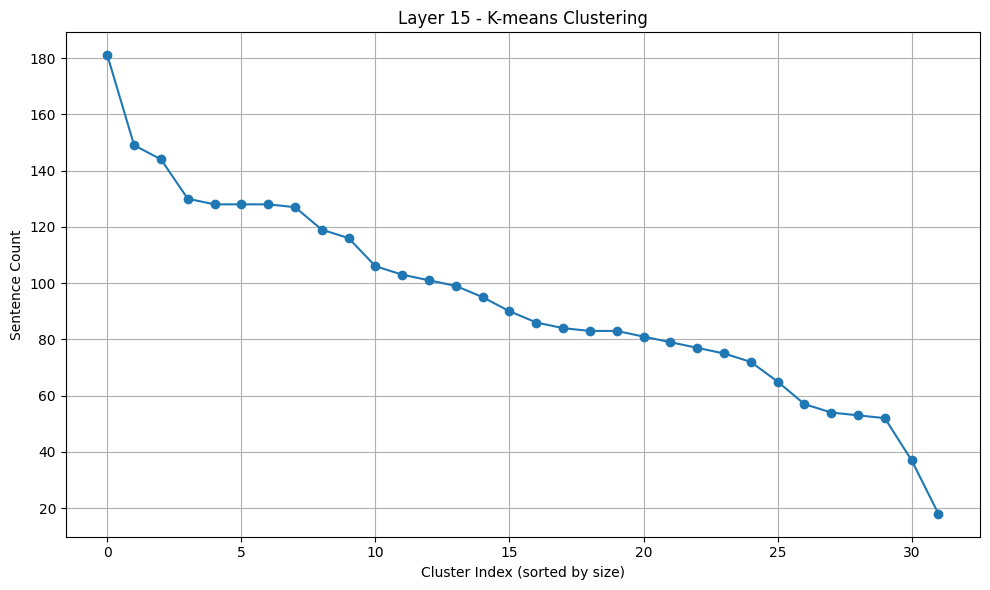

Saved plot: new_clustering_wiki_plots/Last Layer - K-means Clustering_wiki.png


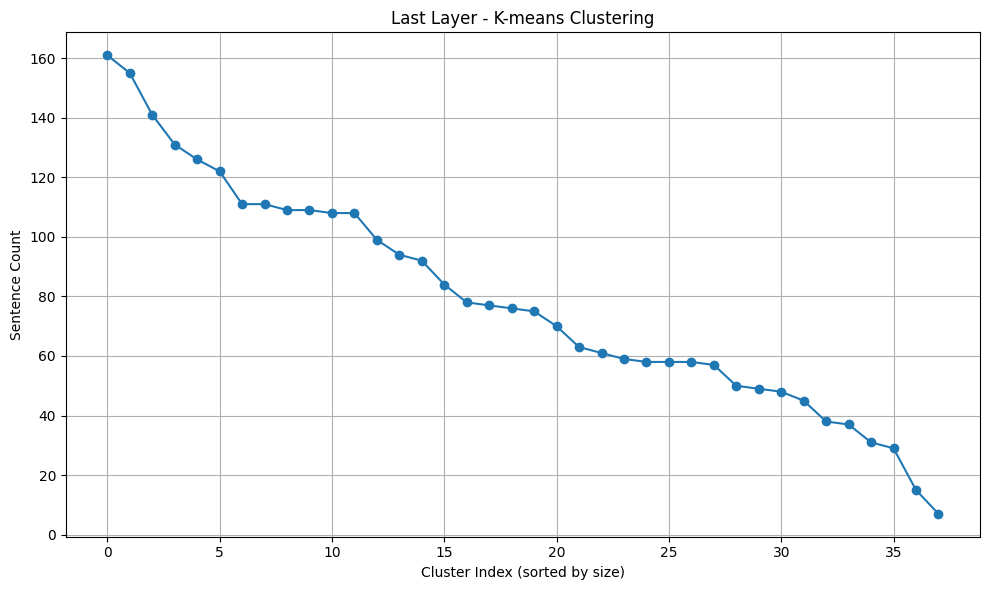

Saved plot: new_clustering_wiki_plots/Layer 15 - Cosine Similarity Grouping (Best Threshold for Layer 15)_wiki.png


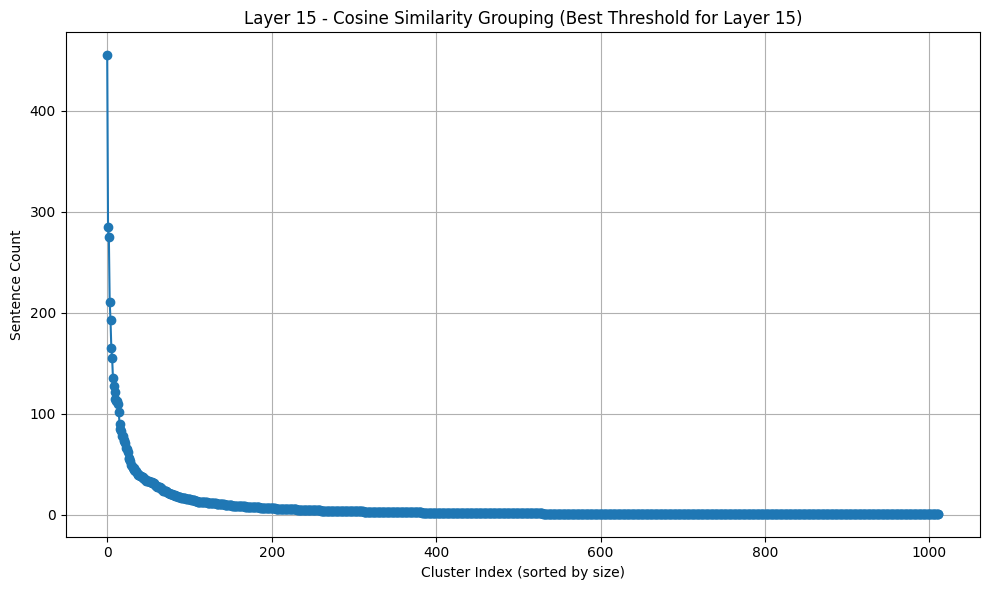

Saved plot: new_clustering_wiki_plots/Final Layer - Cosine Similarity Grouping (Best Threshold for Layer 15)_wiki.png


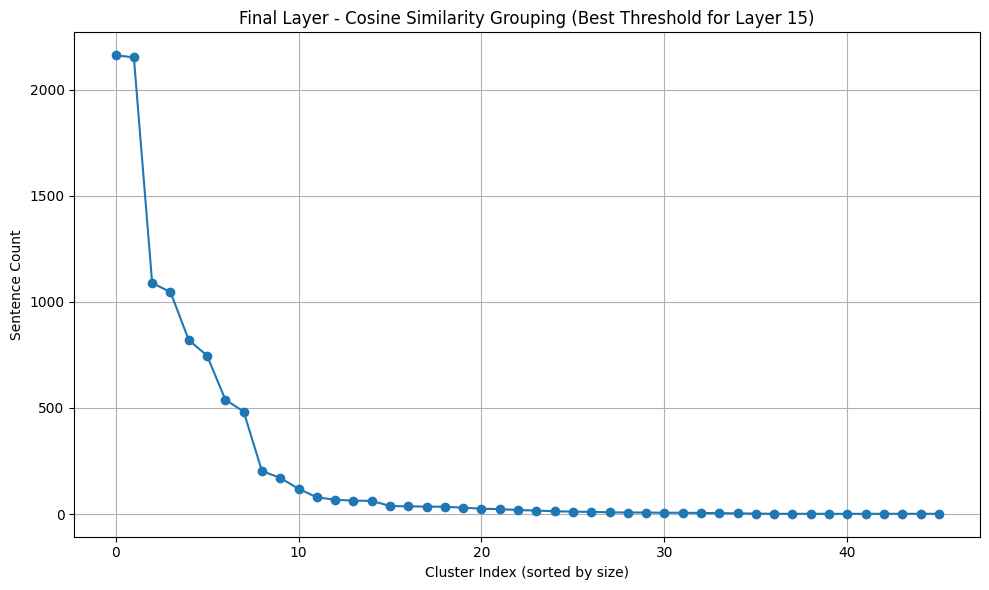

Saved plot: new_clustering_wiki_plots/Layer 15 - Cosine Similarity Grouping (Best Threshold for Final Layer)_wiki.png


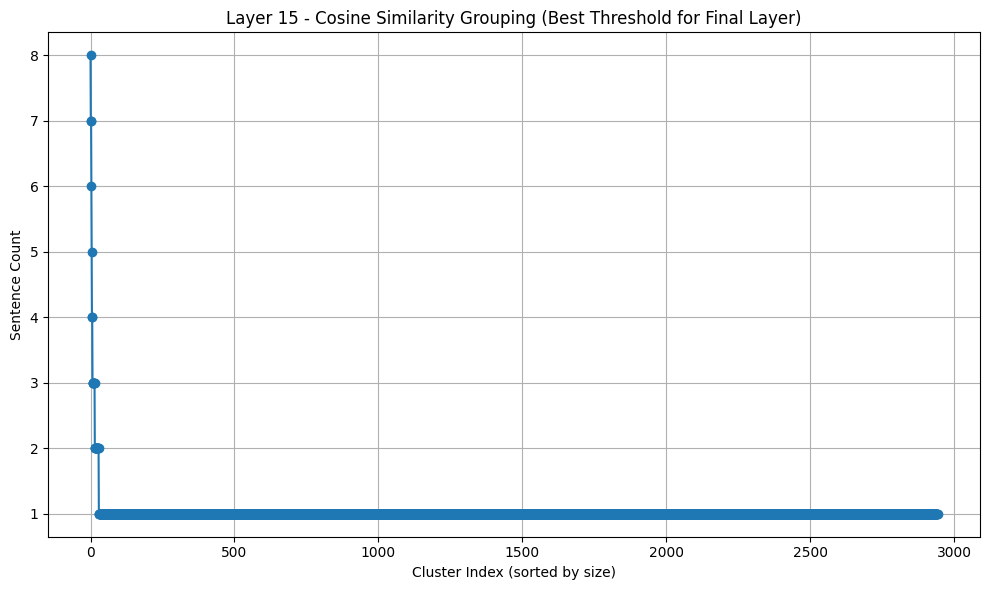

Saved plot: new_clustering_wiki_plots/Final Layer - Cosine Similarity Grouping (Best Threshold for Final Layer)_wiki.png


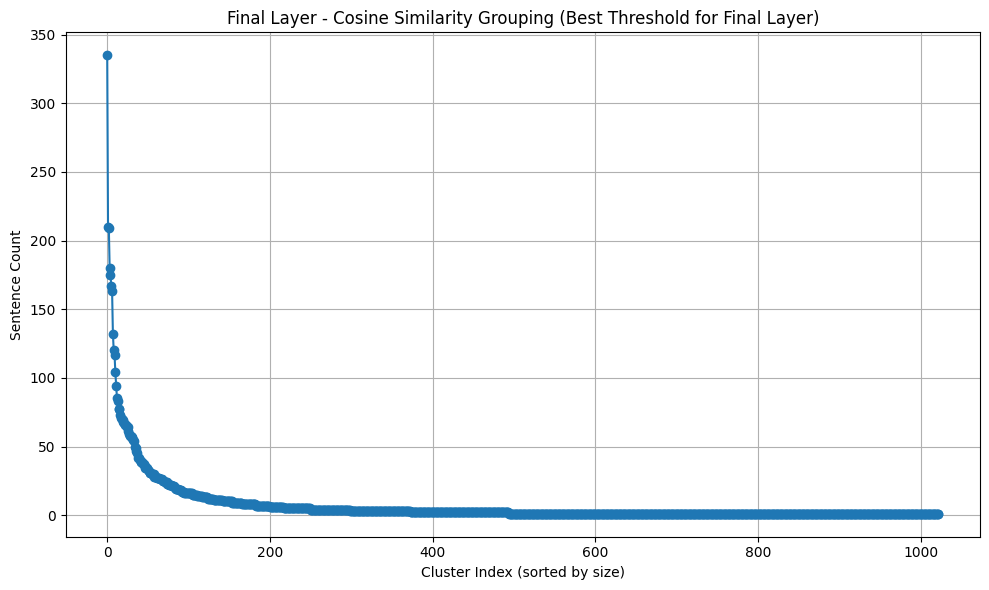

Saved plot: new_clustering_wiki_plots/Layer 15 - HDBSCAN Clustering (Layer15 Best Params)_wiki.png


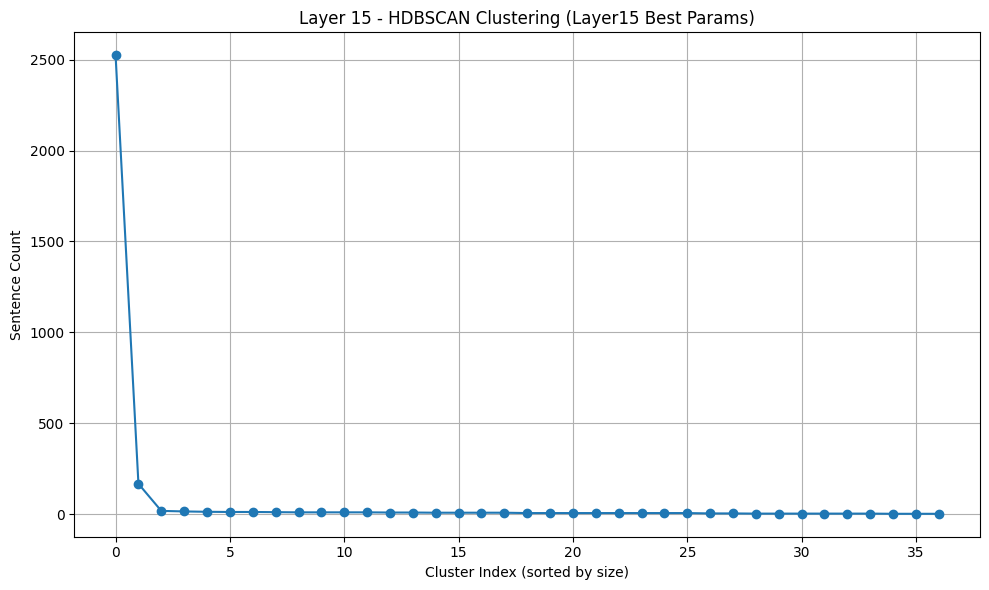

Saved plot: new_clustering_wiki_plots/Final Layer - HDBSCAN Clustering (Layer15 Best Params)_wiki.png


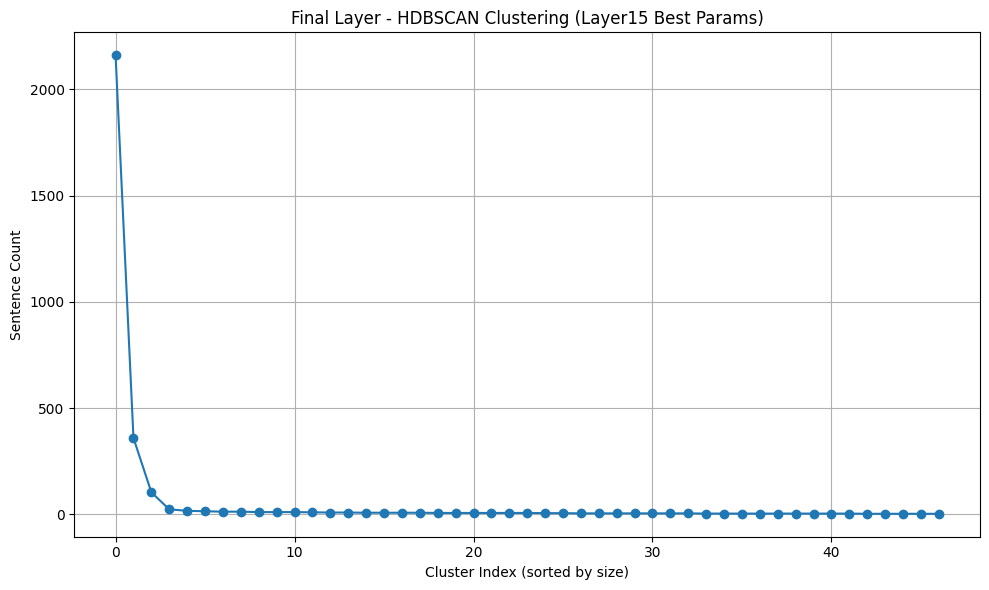

Saved plot: new_clustering_wiki_plots/Layer 15 - HDBSCAN Clustering (Layer22 Best Params)_wiki.png


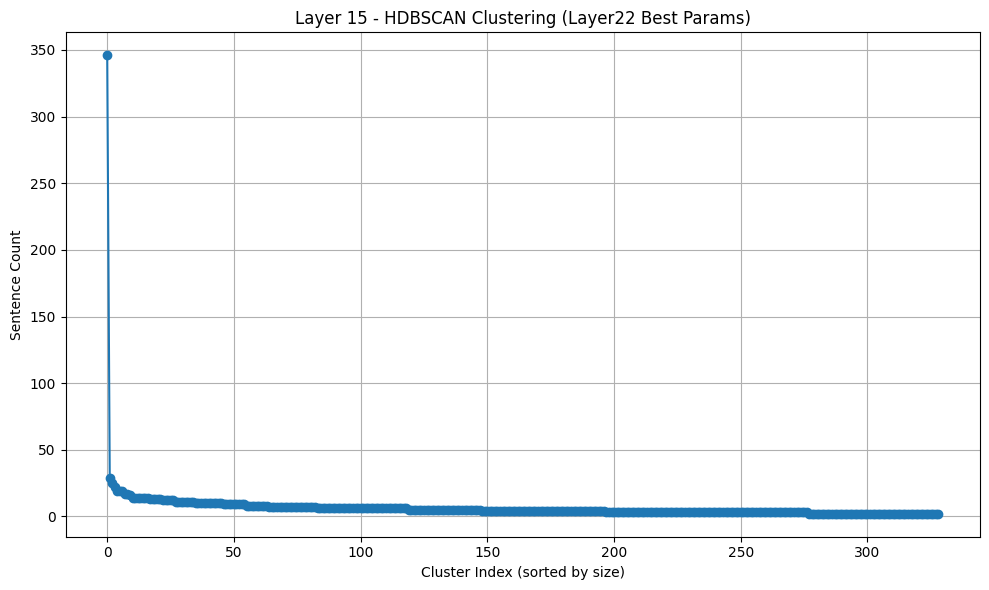

Saved plot: new_clustering_wiki_plots/Final Layer - HDBSCAN Clustering (Layer22 Best Params)_wiki.png


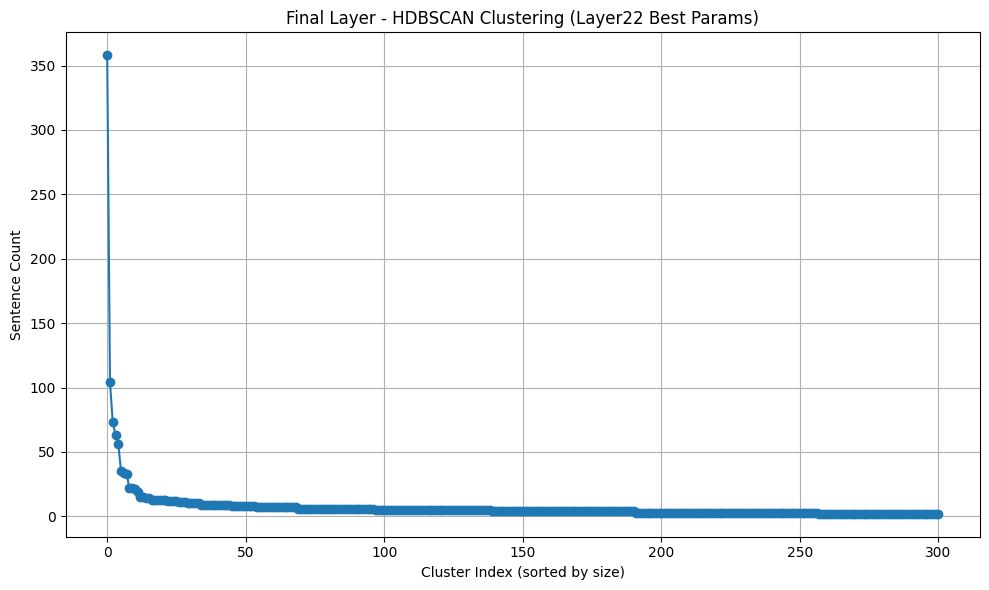

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import os

os.makedirs("new_clustering_wiki_plots", exist_ok=True)

vectors = [
    (vector_sent_dbscan_middle, "Layer 15 - DBSCAN Clustering", "middle", "dbscan"),
    (vector_sent_dbscan_last, "Last Layer - DBSCAN Clustering", "last", "dbscan"),

    (vector_sent_kmeans_mid, "Layer 15 - K-means Clustering", "middle", "kmeans"),
    (vector_sent_kmeans_last, "Last Layer - K-means Clustering", "last", "kmeans"),

    (vector_best_mid_thres_cosine_grouping_middle, "Layer 15 - Cosine Similarity Grouping (Best Threshold for Layer 15)", "middle", "cosine"),
    (vector_best_mid_thres_cosine_grouping_final, "Final Layer - Cosine Similarity Grouping (Best Threshold for Layer 15)", "last", "cosine"),
    (vector_best_final_thres_cosine_grouping_middle, "Layer 15 - Cosine Similarity Grouping (Best Threshold for Final Layer)", "middle", "cosine"),
    (vector_best_final_thres_cosine_grouping_final, "Final Layer - Cosine Similarity Grouping (Best Threshold for Final Layer)", "last", "cosine"),

    (vector_sent_hdbscan_layer15_best15, "Layer 15 - HDBSCAN Clustering (Layer15 Best Params)", "middle", "hdbscan"),
    (vector_sent_hdbscan_layer22_best15, "Final Layer - HDBSCAN Clustering (Layer15 Best Params)", "last", "hdbscan"),
    (vector_sent_hdbscan_layer15_best22, "Layer 15 - HDBSCAN Clustering (Layer22 Best Params)", "middle", "hdbscan"),
    (vector_sent_hdbscan_layer22_best22, "Final Layer - HDBSCAN Clustering (Layer22 Best Params)", "last", "hdbscan"),
]

for vector, title, layer_name, method_name in vectors:
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(vector)), sorted(vector, reverse=True), marker='o')
    plt.title(title)
    plt.xlabel('Cluster Index (sorted by size)')
    plt.ylabel('Sentence Count')
    plt.grid(True)
    plt.tight_layout()

    filename = f"new_clustering_wiki_plots/{title}_wiki.png"
    plt.savefig(filename)
    print(f"Saved plot: {filename}")
    plt.show()

layer_titles = ["2/3th Layer", "Last Layer"]
layer_names = ["middle", "last"]
clustering_methods = ["dbscan", "kmeans", "cosine"]



In [ ]:
import shutil
shutil.make_archive('/content/new_clustering_wiki_plots', 'zip', 'new_clustering_wiki_plots')
from google.colab import files
files.download('new_clustering_wiki_plots.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved plot: new_loglog_wiki_plots/loglog_Layer 15 - DBSCAN Clustering_wiki.png


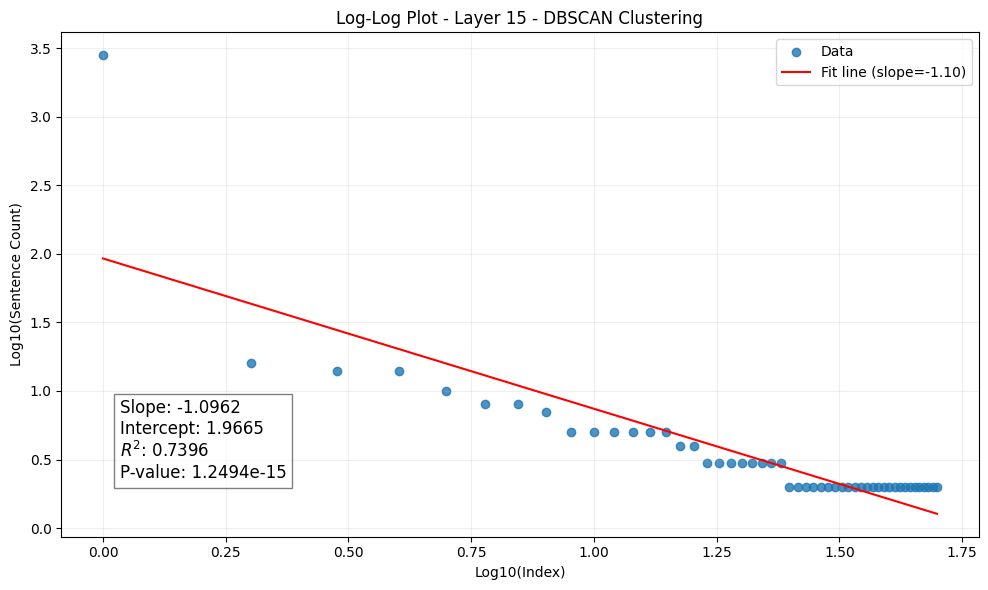


Regression Results for Layer 15 - DBSCAN Clustering:
   - Slope: -1.0962
   - Intercept: 1.9665
   - R-squared: 0.7396
   - P-value: 1.2494e-15
Saved plot: new_loglog_wiki_plots/loglog_Last Layer - DBSCAN Clustering_wiki.png


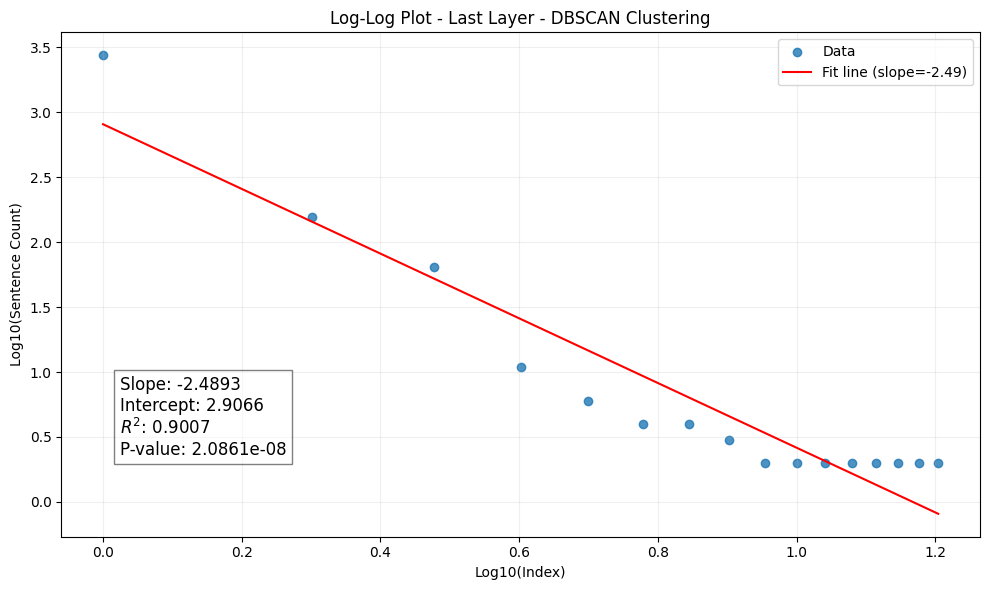


Regression Results for Last Layer - DBSCAN Clustering:
   - Slope: -2.4893
   - Intercept: 2.9066
   - R-squared: 0.9007
   - P-value: 2.0861e-08
Saved plot: new_loglog_wiki_plots/loglog_Layer 15 - K-means Clustering_wiki.png


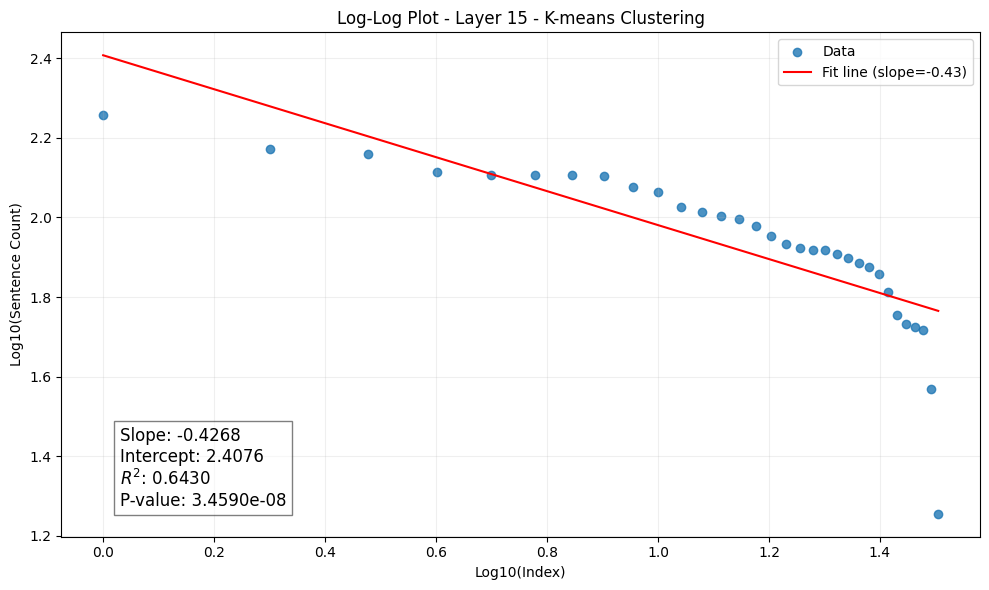


Regression Results for Layer 15 - K-means Clustering:
   - Slope: -0.4268
   - Intercept: 2.4076
   - R-squared: 0.6430
   - P-value: 3.4590e-08
Saved plot: new_loglog_wiki_plots/loglog_Last Layer - K-means Clustering_wiki.png


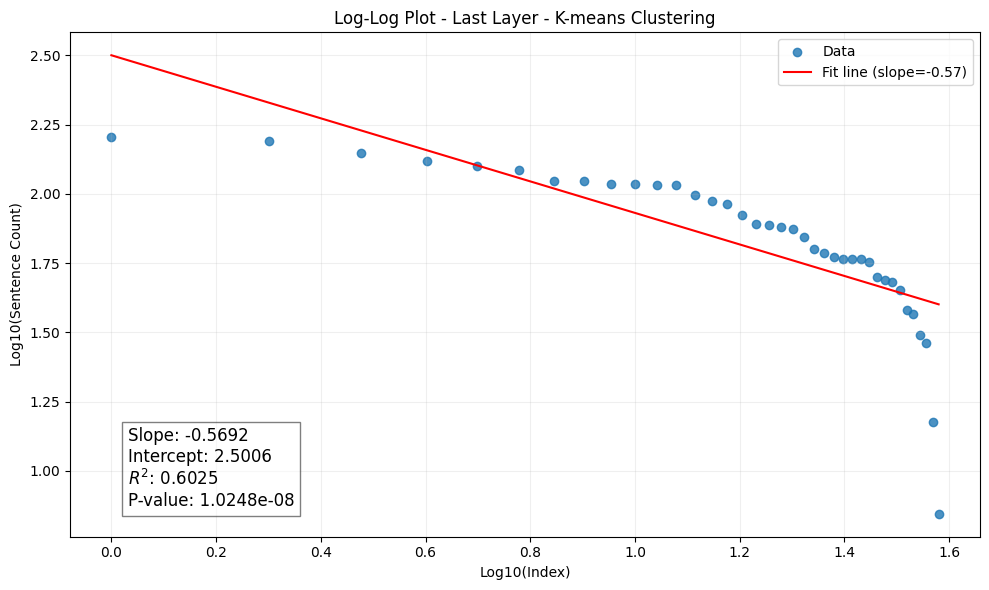


Regression Results for Last Layer - K-means Clustering:
   - Slope: -0.5692
   - Intercept: 2.5006
   - R-squared: 0.6025
   - P-value: 1.0248e-08
Saved plot: new_loglog_wiki_plots/loglog_Layer 15 - Cosine Similarity Grouping (Best Threshold for Layer 15)_wiki.png


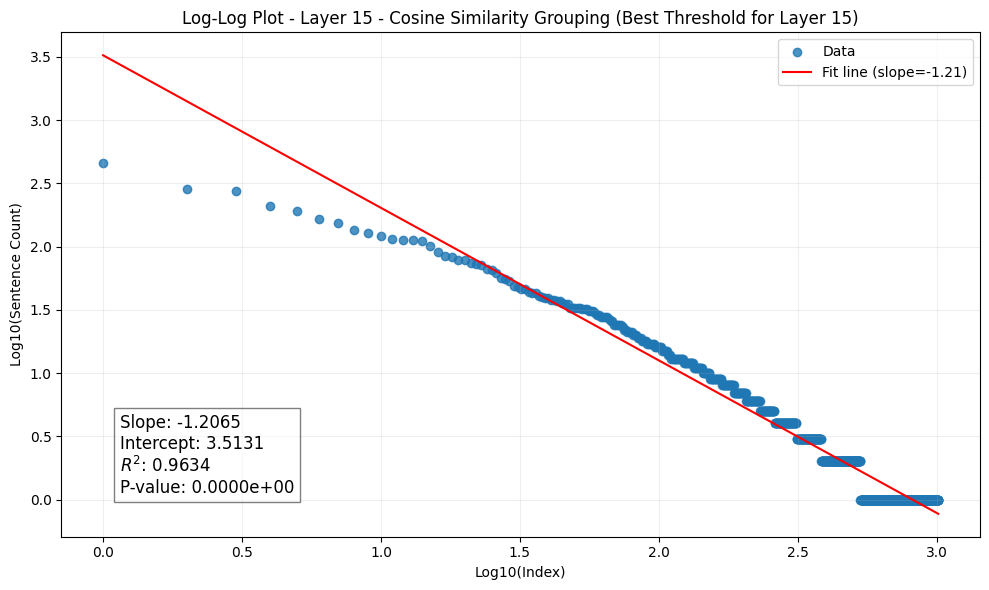


Regression Results for Layer 15 - Cosine Similarity Grouping (Best Threshold for Layer 15):
   - Slope: -1.2065
   - Intercept: 3.5131
   - R-squared: 0.9634
   - P-value: 0.0000e+00
Saved plot: new_loglog_wiki_plots/loglog_Final Layer - Cosine Similarity Grouping (Best Threshold for Layer 15)_wiki.png


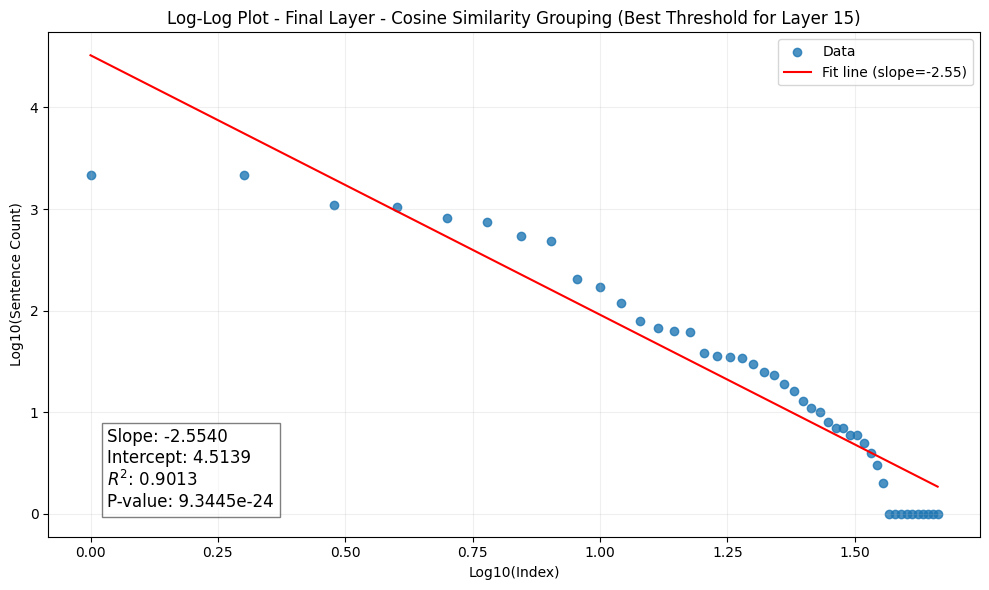


Regression Results for Final Layer - Cosine Similarity Grouping (Best Threshold for Layer 15):
   - Slope: -2.5540
   - Intercept: 4.5139
   - R-squared: 0.9013
   - P-value: 9.3445e-24
Saved plot: new_loglog_wiki_plots/loglog_Layer 15 - Cosine Similarity Grouping (Best Threshold for Final Layer)_wiki.png


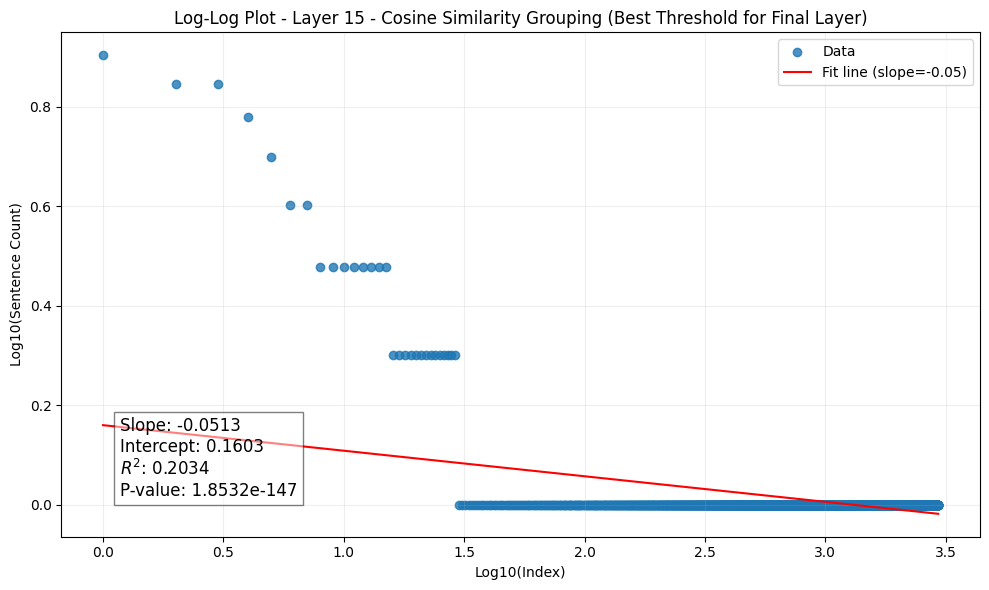


Regression Results for Layer 15 - Cosine Similarity Grouping (Best Threshold for Final Layer):
   - Slope: -0.0513
   - Intercept: 0.1603
   - R-squared: 0.2034
   - P-value: 1.8532e-147
Saved plot: new_loglog_wiki_plots/loglog_Final Layer - Cosine Similarity Grouping (Best Threshold for Final Layer)_wiki.png


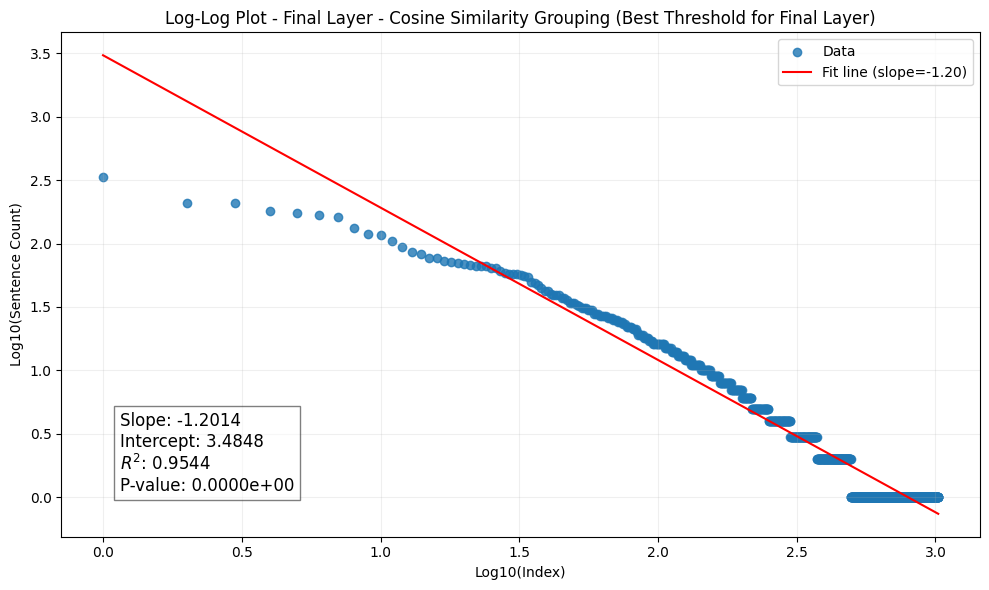


Regression Results for Final Layer - Cosine Similarity Grouping (Best Threshold for Final Layer):
   - Slope: -1.2014
   - Intercept: 3.4848
   - R-squared: 0.9544
   - P-value: 0.0000e+00
Saved plot: new_loglog_wiki_plots/loglog_Layer 15 - HDBSCAN Clustering (Layer15 Best Params)_wiki.png


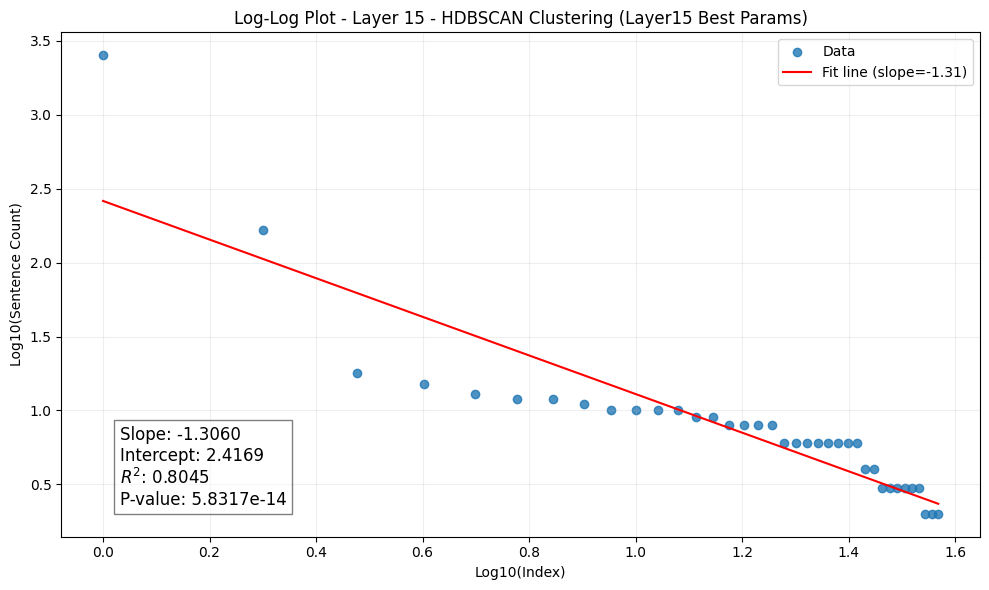


Regression Results for Layer 15 - HDBSCAN Clustering (Layer15 Best Params):
   - Slope: -1.3060
   - Intercept: 2.4169
   - R-squared: 0.8045
   - P-value: 5.8317e-14
Saved plot: new_loglog_wiki_plots/loglog_Final Layer - HDBSCAN Clustering (Layer15 Best Params)_wiki.png


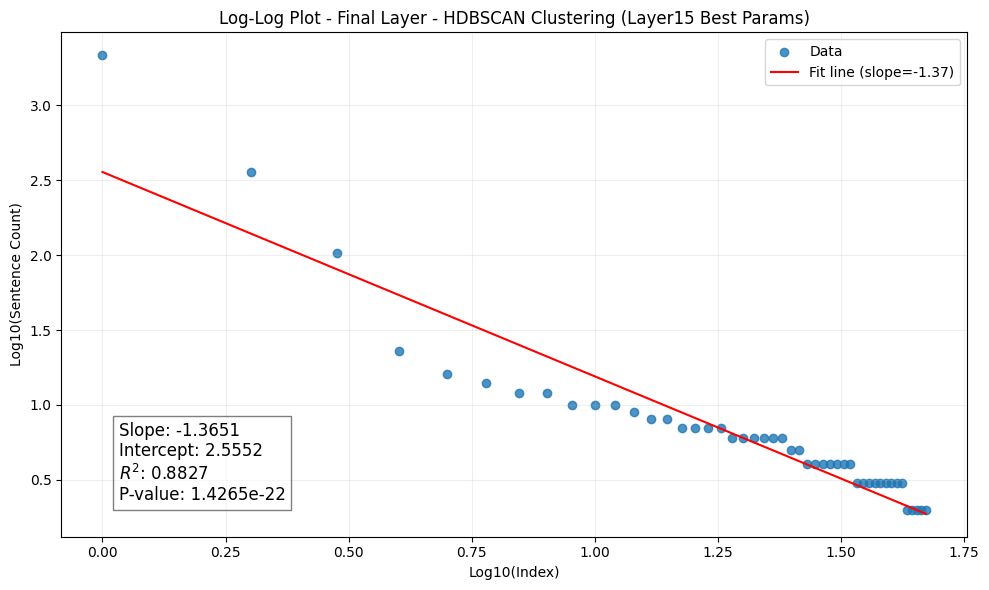


Regression Results for Final Layer - HDBSCAN Clustering (Layer15 Best Params):
   - Slope: -1.3651
   - Intercept: 2.5552
   - R-squared: 0.8827
   - P-value: 1.4265e-22
Saved plot: new_loglog_wiki_plots/loglog_Layer 15 - HDBSCAN Clustering (Layer22 Best Params)_wiki.png


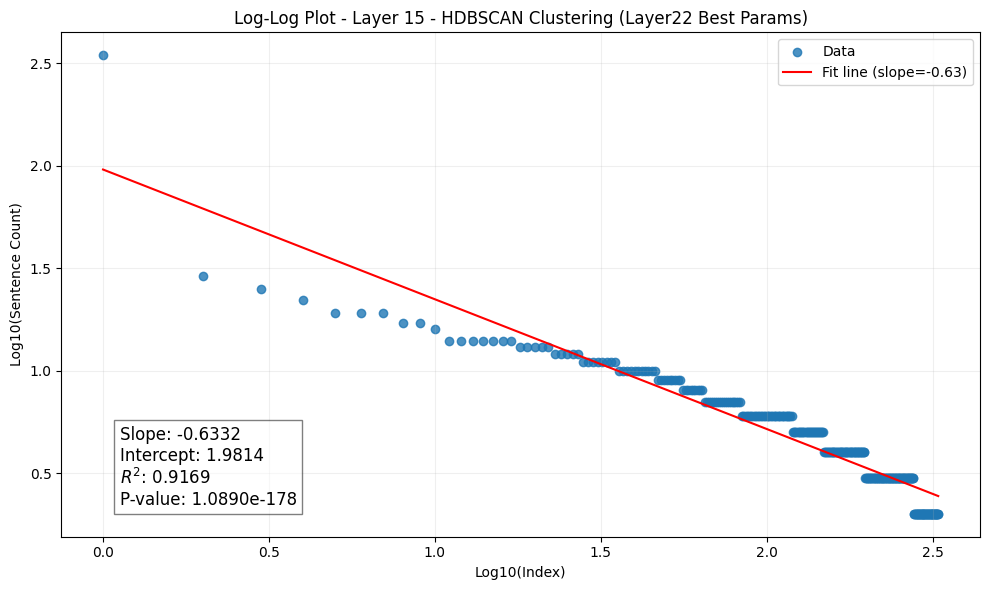


Regression Results for Layer 15 - HDBSCAN Clustering (Layer22 Best Params):
   - Slope: -0.6332
   - Intercept: 1.9814
   - R-squared: 0.9169
   - P-value: 1.0890e-178
Saved plot: new_loglog_wiki_plots/loglog_Final Layer - HDBSCAN Clustering (Layer22 Best Params)_wiki.png


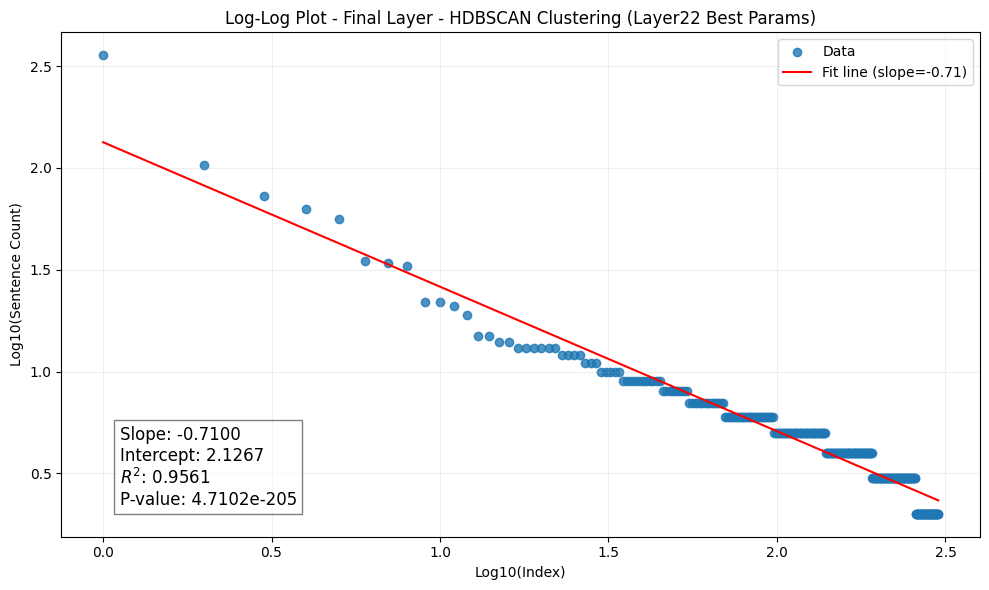


Regression Results for Final Layer - HDBSCAN Clustering (Layer22 Best Params):
   - Slope: -0.7100
   - Intercept: 2.1267
   - R-squared: 0.9561
   - P-value: 4.7102e-205


In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import os

os.makedirs("new_loglog_wiki_plots", exist_ok=True)

def linear_regression(counts):
    valid_counts = counts[counts > 0]
    if len(valid_counts) <= 1:
        return None, None, 0, 0, 0, 1, None
    x = np.log10(np.arange(1, len(valid_counts)+1))
    y = np.log10(valid_counts)
    slope, intercept, r_val, p_val, std_err = linregress(x, y)
    y_pred = slope * x + intercept
    return x, y, slope, intercept, r_val, p_val, y_pred

for vector, title, layer_key, method_key in vectors:
    x, y, slope, intercept, r_val, p_val, y_pred = linear_regression(np.array(vector))
    if x is None:
        print(f"Regression failed for {title} - not enough valid data points")
        continue

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.8, label='Data')
    plt.plot(x, y_pred, 'r-', label=f'Fit line (slope={slope:.2f})')

    plt.title(f"Log-Log Plot - {title}")
    plt.xlabel('Log10(Index)')
    plt.ylabel('Log10(Sentence Count)')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend()

    text_x = min(x) + (max(x) - min(x)) * 0.02
    text_y = min(y) + (max(y) - min(y)) * 0.02
    plt.text(text_x, text_y,
             f"Slope: {slope:.4f}\nIntercept: {intercept:.4f}\n$R^2$: {r_val**2:.4f}\nP-value: {p_val:.4e}",
             fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()
    filename = f"new_loglog_wiki_plots/loglog_{title}_wiki.png"
    plt.savefig(filename)
    print(f"Saved plot: {filename}")
    plt.show()

    method = title.split(" - ")[1]
    layer = title.split(" - ")[0]

    print(f"\nRegression Results for {title}:")
    print(f"   - Slope: {slope:.4f}")
    print(f"   - Intercept: {intercept:.4f}")
    print(f"   - R-squared: {r_val**2:.4f}")
    print(f"   - P-value: {p_val:.4e}")


methods = ["dbscan", "kmeans", "cosine", "graph", "hdbscan"]
layers = ["middle", "last"]
method_labels = ["DBSCAN", "K-means", "Cosine Similarity", "Graph-based", "HDBSCAN"]
layer_labels = ["Middle Layer", "Last Layer"]

slope_matrix = np.zeros((len(methods), len(layers)))
r2_matrix = np.zeros((len(methods), len(layers)))




In [ ]:
import shutil
shutil.make_archive('/content/new_loglog_wiki_plots', 'zip', 'new_loglog_wiki_plots')
from google.colab import files
files.download('new_loglog_wiki_plots.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>